# InsideAirbnb - London 

### Questions discussed in this report: 
1. Is Airbnb “out of control” in London?

2. How many professional landlords are there?

3. How many properties would be affected by the opposition’s proposal?
   - direct effects: illegal properties and professional properties
   - indirect effects: all properties
     
   (need to explain the mechanism of effect on properties in this question)

   - further: how would the effects be (discussed in question 4)
   - question: what kind of effects they could be? only negative or negative & positive?

4. What are the likely pros and cons of the opposition’s proposal? (for the Mayor, for the residents, for the city)

5. Can the story be reframed as a positive one about social mobility or housing opportunity?


## 1. EDA

### 1.0. Caching Remote Data

In [1]:
# Import libraries needed for this analysis
from pathlib import Path
from requests import get
from functools import wraps
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib
import matplotlib.font_manager

In [2]:
def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        url = Path(src) 
        fn  = url.name  
        dsn = Path(f"{dst}/{fn}") 
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create...
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

### 1.1. Data Loading

#### 1.1.0 Read Data

In this section, we read data remotely with the caching function above.

In [3]:
# Set download URL
ymd  = '20250615'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.csv.gz'

# Read csv data
df = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,651 x 79


In [4]:
ddir  = Path('data/geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath + 'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath + 'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath + 'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

+ data/geo/Boroughs.gpkg?raw=true found locally!
+ data/geo/Water.gpkg?raw=true found locally!
+ data/geo/Greenspace.gpkg?raw=true found locally!
Done.


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Boroughs.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Water.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Greenspace.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(


#### 1.1.1 Save Raw Data
Then, we want to save the raw Data in case we need them again in the later exploring.

In [5]:
# Create a diractory for raw data
path = Path(f'data/raw/{Path(url).name}') 
print(f"Writing to: {path}")

# Save raw data locally
if not path.parent.exists(): 
    print(f"Creating {path.parent}")
    path.parent.mkdir(parents=True, exist_ok=True)

if not path.exists():  
    df.to_csv(path, index=False)
    print("Done.")

Writing to: data/raw/20250615-London-listings.csv.gz


### 1.2 EDA - Data Processing

#### 1.2.0. Info

We run the chunk below to have a general sense of what are in the raw data, such as data type and columns.

In [6]:
# Get the information of the whole data set
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96651 entries, 0 to 96650
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            96651 non-null  int64  
 1   listing_url                                   96651 non-null  object 
 2   scrape_id                                     96651 non-null  int64  
 3   last_scraped                                  96651 non-null  object 
 4   source                                        96651 non-null  object 
 5   name                                          96651 non-null  object 
 6   description                                   93806 non-null  object 
 7   neighborhood_overview                         41983 non-null  object 
 8   picture_url                                   96642 non-null  object 
 9   host_id                                       96651 non-null 

In [7]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,9.665100e+04,9.665100e+04,9.665100e+04,96613.000000,96613.000000,0.0,96651.000000,96651.000000,96651.000000,62730.000000,...,71443.000000,71466.000000,71442.000000,71442.000000,0.0,96651.000000,96651.000000,96651.000000,96651.000000,71487.000000
mean,6.526020e+17,2.025061e+13,2.091790e+08,46.263577,76.334945,NaN,51.509818,-0.127087,3.316520,1.358018,...,4.792937,4.816368,4.733591,4.623804,NaN,16.389370,14.170831,2.164716,0.025763,0.958877
std,5.708808e+17,0.000000e+00,2.141266e+08,357.645418,561.614957,NaN,0.048945,0.100853,2.073674,0.725580,...,0.431668,0.423297,0.408804,0.506245,NaN,53.299577,52.845630,8.543681,0.626042,1.282595
min,1.391300e+04,2.025061e+13,2.594000e+03,1.000000,1.000000,NaN,51.295937,-0.496760,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.955518e+07,2.025061e+13,2.673176e+07,1.000000,1.000000,NaN,51.484240,-0.189060,2.000000,1.000000,...,4.760000,4.800000,4.650000,4.500000,NaN,1.000000,0.000000,0.000000,0.000000,0.150000
50%,8.123206e+17,2.025061e+13,1.128684e+08,2.000000,3.000000,NaN,51.513791,-0.126990,2.000000,1.000000,...,4.930000,4.970000,4.850000,4.750000,NaN,2.000000,1.000000,0.000000,0.000000,0.500000
75%,1.197378e+18,2.025061e+13,4.063762e+08,9.000000,14.000000,NaN,51.539099,-0.067880,4.000000,1.500000,...,5.000000,5.000000,5.000000,4.950000,NaN,8.000000,5.000000,1.000000,0.000000,1.230000
max,1.439673e+18,2.025061e+13,7.001298e+08,4884.000000,8723.000000,NaN,51.682630,0.278960,16.000000,26.000000,...,5.000000,5.000000,5.000000,5.000000,NaN,495.000000,495.000000,116.000000,25.000000,38.410000


#### 1.2.1. Columns

In [8]:
# Check columns in the data set
print(df.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

Given the result of columns above, we can tell there are many columns which are not useful for this analysis, therefore, we got `cols_selected` below by copying the output of (`df.columns.to_list()`) and then removing the fields that we thought we weren’t interested in.

In [9]:
cols_selected = ['id', 'listing_url', 'source', 'description', 'host_id', 'host_name', 'host_is_superhost',
                'host_listings_count', 'calculated_host_listings_count', 
                 'room_type', 'property_type','accommodates', 'bedrooms', 
                 'beds', 'price', 'minimum_nights','maximum_nights',
                'estimated_occupancy_l365d', 'number_of_reviews', 'number_of_reviews_ltm', 'reviews_per_month',
                'review_scores_rating', 'latitude', 'longitude', 'neighbourhood_cleansed', 
                'host_total_listings_count', 'bathrooms', 'bathrooms_text', 
                'first_review', 'last_review']
len(cols_selected)

30

In [10]:
# Get a new df with selected cols
df = df[cols_selected]
print(f"The new data frame is {df.shape[0]:,} x {df.shape[1]}")

The new data frame is 96,651 x 30


#### 1.2.2. Dealing with NaNs and Nulls

Combined with results from `df.info()` and `df.describe()`, we see that a number of data types that aren’t ‘appropriate’ for their contents: the id columns are floats; the dates aren’t dates; there’s a boolean that’s not a boolean… It would be nice to fix these!

We started from exploring rows with NaN values. In the chunck below, we listed a exmaple from `price` columns. There are several more columns with the same issue, such `room_type` and `id`.

In [11]:
# Identify Problem Rows
df[df.price.isna()][['id','price','room_type']].head(3)

,id,price,room_type
12,271122,NaN,Private room
13,425143,NaN,Entire home/apt
16,427229,NaN,Private room


In [12]:
# There is no NaN in `id`
df[df.host_id.isna()][['id','host_id','price','room_type']]

,id,host_id,price,room_type


In [13]:
df[df.id.isna()][['id','price','room_type']]

,id,price,room_type


In [14]:
# Drop NaN
print(f"Data frame contains {df.shape[0]:,} rows.")
df.drop(df[df.host_id.isna()].index.array, axis=0, inplace=True)
print(f"Data frame contains {df.shape[0]:,} rows.")

Data frame contains 96,651 rows.
Data frame contains 96,651 rows.


We have checked there is no NaN values in `id` or in `host_id`, so we can now turn to counting NaNs or Nulls in the remaining data with a view to identifying other rows that can probably be dropped.

In [15]:
# returns a data frame with all values set to True/False according to Null status
df.isnull() 
# counts these values by column (we'll see another option in a moment)
df.isnull().sum(axis=0) 
# Sort results in `

#descending order
df.isnull().sum(axis=0).sort_values(ascending=False) 

beds                              33975
price                             33967
bathrooms                         33921
last_review                       25164
review_scores_rating              25164
reviews_per_month                 25164
first_review                      25164
bedrooms                          12580
description                        2845
host_is_superhost                  1823
bathrooms_text                      149
host_name                            40
host_listings_count                  38
host_total_listings_count            38
number_of_reviews_ltm                 0
neighbourhood_cleansed                0
longitude                             0
latitude                              0
id                                    0
number_of_reviews                     0
estimated_occupancy_l365d             0
maximum_nights                        0
listing_url                           0
accommodates                          0
property_type                         0


Based on the results above per column, it is sensible to retain all columns we selected.

In [16]:
# counting nulls by row
df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

4622     11
3646     11
6122     11
5535     11
5155     11
187      10
232      10
683      10
82       10
35147    10
dtype: int64

<class 'pandas.core.series.Series'>


<Axes: ylabel='Frequency'>

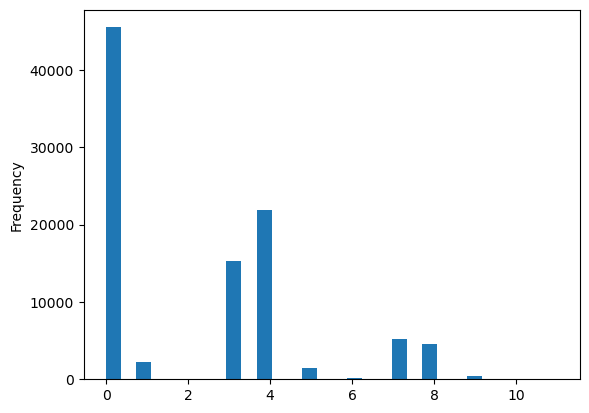

In [17]:
# save the results to a variable called probs
probs = df.isnull().sum(axis=1)
print(type(probs))       
probs.plot.hist(bins=30) 

The histogram shows that a significant proportion of data has zero or one missing value, while only a small number of rows have more than five missing values. It is therefore reasonable to retain all rows for further analysis.

#### 1.2.3. Fix Data Types

In this section, we are correcting data types that did not match the interpretation.

In [18]:
# Boolean
bools = ['host_is_superhost']
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace({'f':False, 't':True}).astype('bool')

Converting host_is_superhost


In [19]:
# Date
dates = ['first_review','last_review']
print(f"Currently {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")
for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d])

print(f"Now {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")


Currently last_review is of type 'object' 

Converting first_review
Converting last_review
Now last_review is of type 'datetime64[ns]' 



# Remove below chunks?
We do not need active hosts - this was intended for the housing price.

We tend to use literature review for the out of control evidence in price.

In [20]:
# # year-number of last reviews,

# source_counts = df['source'].value_counts()
# print("\nsource：\n", source_counts)

# review_cols = ['first_review', 'last_review']
# na_counts = df[review_cols].isna().sum()

# print("review_is_NULL：")
# print(na_counts)

# import matplotlib.pyplot as plt

# monthly_counts = df.set_index('last_review').resample('12ME').size()

# plt.figure(figsize=(12,5))
# plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
# plt.xlabel('Year-Month')
# plt.ylabel('Number of Last Reviews')
# plt.title('Number of Last Reviews per 12-Month Period')
# plt.xticks(rotation=45)

# plt.tight_layout()
# plt.show()



In [21]:
# # counting review_time percentage
# # validate active listings

# now = pd.Timestamp('2025-06-15')
# windows = [12, 24, 36, 48, 60, 72, 84]  

# reviewed_listings = df[df['last_review'].notna()]
# total_reviewed = reviewed_listings.shape[0]

# print(f"listings_have_reviews: {total_reviewed}")
# for w in windows:
#     cutoff = now - pd.DateOffset(months=w)
#     active_count = reviewed_listings[reviewed_listings['last_review'] >= cutoff].shape[0]
#     active_ratio = active_count / total_reviewed * 100
#     print(f"active last {w} month: {active_count}/{total_reviewed} → {active_ratio:.2f}%")


# no_review_listings1 = df[df['last_review'].isna() & (df['number_of_reviews'].isna() | (df['number_of_reviews'] == 0))]
# no_review_listings2 = df[df['last_review'].isna() & (df['number_of_reviews_ltm'].isna() | (df['number_of_reviews_ltm'] == 0))]
# len(no_review_listings1)
# len(no_review_listings2)

# print("Listings with no first/last review = 0 reviews")
# print("Only select out active listings (can be down later)")
# # Listings with no first/last review = 0 reviews
# # Only select out active listings (can be down later)

In [22]:
# categories
cats = ['property_type','room_type']
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")

Currently room_type is of type 'object' 

Converting property_type
Converting room_type
Currently room_type is of type 'category' 



In [23]:
# strings
money = ['price']
for m in money:
    print(f"Converting {m}")
    df[m] = df[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


### JL - convert `bathroom_text` into integer 

In [24]:
# string

df["bathrooms_text"].unique()
df["bathrooms_text"] = df["bathrooms_text"].replace({
    "Shared half-bath": "0.5 shared baths",
    "Half-bath": "0.5 baths",
    "Private half-bath": "0.5 baths"
})

df["bathrooms_text"] = df["bathrooms_text"].astype(str)

df["bathrooms_text"] = (
    df["bathrooms_text"]
        .str.split(" ", n=1).str[0]
        .astype(float)
)

print("bathrooms null:", df["bathrooms"].isnull().sum())
print("bathrooms_text null:", df["bathrooms_text"].isnull().sum())

df = df.drop(columns=['bathrooms'])
df.rename(columns={'bathrooms_text': 'bathroom_new'}, inplace=True)

# bathrooms null: 33921
# bathrooms_text null: 149
# col "bathrooms_text" have more valid values

bathrooms null: 33921
bathrooms_text null: 149


We use the column `bathrooms_text` to identify the number of bathrooms per listing, as there are more missing values in the column `bathrooms`. We also made comparison between two columns for accuracy.

<!-- After investigation from the metadata, we know that both `bathrooms` and `bathrooms_text` representing the same idea of a listing, while the only difference is the format. For `bathrooms` column, we have a column of numeric data while we have a text data for `bathrooms_text`. After extracting the number of bathrooms from `bathrooms_text`, we have a new column, and under the comparison with `bathrooms`, we notice there are more null values in the column of `bathrooms`. Therefore, we drop the `bathrooms` and keep the new column we created. -->

`host_listings_count`: The number of listings the host has in total on the Airbnb platform (may include other cities). **This is the host-provided value.**

`host_total_listings_count`: The total number of listings the host manages globally.

`calculated_host_listings_count`: The number of listings the host manages in the current city/area of the dataset (e.g., only London). This value is calculated by the scraper, not provided by the host.

`Accomoundates`: The maximum number of guests the listing is advertised to sleep.

For the Question 2 about the professional landlord, we're mainly interested about `calculated_host_listings_count`.

In [25]:
# col types
ints = ['id', 'host_id',
        'host_listings_count', 
        'accommodates', 'bedrooms', 'beds', 'minimum_nights','maximum_nights',
        'estimated_occupancy_l365d', 'number_of_reviews_ltm', 'reviews_per_month',
        'host_total_listings_count', 'bathroom_new', 'calculated_host_listings_count']

print(df[ints].dtypes)

id                                  int64
host_id                             int64
host_listings_count               float64
accommodates                        int64
bedrooms                          float64
beds                              float64
minimum_nights                      int64
maximum_nights                      int64
estimated_occupancy_l365d           int64
number_of_reviews_ltm               int64
reviews_per_month                 float64
host_total_listings_count         float64
bathroom_new                      float64
calculated_host_listings_count      int64
dtype: object


In [30]:
# # dealing with NULL/NAN/"" in numeric col
# # transforming int type to UInt16(An extended form of int, allow keeping NULL)

# int_cols = [col for col in df.columns if str(df[col].dtype).startswith(('int', 'UInt'))]

# na_report = df[int_cols].isna().sum()

# print("number of NULL rows：")
# print(na_report)

# cols_with_nulls = ["host_listings_count", "bedrooms", "beds"]

# for col in cols_with_nulls:
#     df[col] = df[col].astype("UInt16") 

### 1.3 Saving Clean Data

In [26]:
csv_out = Path(f'data/clean/{path.name}')
pq_out  = Path(f'data/clean/{path.name.replace('.csv.gz','.parquet')}')

if not csv_out.parent.exists():
    print(f"Creating {csv_out.parent}")
    csv_out.parent.mkdir(parents=True, exist_ok=True)
    
df.to_csv(csv_out, index=False)
df.to_parquet(pq_out, index=False)
print(f"Saved {df.shape[0]:,} rows of {df.shape[1]:,} columns to {csv_out.resolve()}")
print("Done.")

Saved 96,651 rows of 29 columns to /home/jovyan/work/data/clean/20250615-London-listings.csv.gz
Done.


#### Data filtering
JL 

last_review，一年/两年数量对比，选择肘点

### Question 2: Professional Landlords

Strategy:

1. group_by `host_id`
2. sum the count of listings manually
3. compare the sum result with `calculated_host_listings_count` to check the accuracy
4. filter by `room_type`

**Rationale for Professional Classification**

The goal of classifying a host as "professional" is to identify businesses focused on commercial short-term rental income rather than casual income from spare space. It is robust to combine the concepts of Scale (number of listings) and Intent (room type) to classify a professional landlord.

1. Criterion 1: Scale (Quantity)
   - Metric Used: `calculated_host_listings_count` (manual verification needed).
   - Threshold: $\geq 2$ listings.
   - Justification: A host with only one listing could still be commercial, but having two or more listings is the most reliable threshold for establishing a commercial operation. A host renting out multiple separate units is primarily driven by business expansion and investment, not by sharing their primary residence.
   
2. Criterion 2: Intent (Nature)
   - Metric Used: `room_type`
     
   - Categories Selected: Entire home/apt and Hotel room
  
     
   - Justification: This filters the type of housing being rented, distinguishing between sharing a residence and fully commercializing a property:
       - Entire home/apt: Signals the host has completely separated the rental unit from their own residence. This is a dedicated income-generating asset and represents the conversion of residential stock.
       - Hotel room: Explicitly signals the listing is part of the established, professional hospitality industry.
       - Exclusion of Private/Shared rooms: These types are excluded because they suggest the host lives on-site (or is sharing a single unit), which aligns closer to the original sharing economy model. However, we will still analyse from `description` and `review` to make sure these rooms are not shared with guests only (i.e. presence of landlords).

To classify a listing as belonging to a **"Professional Landlord,"** it must satisfy Criterion 1 (Scale) AND its `room_type` must be one of the types selected by Criterion 2 (Intent).

In [27]:
# group by `host_id`

# if the listings >1: then we assume they are pro (literature review)
# we will have a look at the distribution of these >=2 listings 
df['listing_count'] = df.groupby('host_id')['id'].transform('count')
## Filter df to keep only hosts with 2 or more listings
df_multi_host = df[df['listing_count'] > 1].copy()

## Filter df to keep hosts with one listing
df_single_host = df[df['listing_count'] == 1].copy()

col_landlord = ['host_id', 'id', 'room_type', 'property_type', 'listing_count', 
                'calculated_host_listings_count', 'description']
df_multi_host = df_multi_host[col_landlord]
df_single_host = df_single_host[col_landlord]

**Accuracy in `calculated_host_listings_count`**

We firstly compare if the numbers in column `listing_count` are exactly the same as numbers in column `calculated_host_listings_count`. If we check the accuracy of `calculated_host_listings_count`, we can directly use this column for further analysis.

In [28]:
df_multi_host['is_match'] = df_multi_host['listing_count'] == df_multi_host['calculated_host_listings_count']
num_matches = df_multi_host['is_match'].sum()
total_length = len(df_multi_host)
num_mismatches = total_length - num_matches
print(f"Number of mismatches (discrepancies) in multi-listing hosts: {num_mismatches:,}")

Number of mismatches (discrepancies) in multi-listing hosts: 0


In [29]:
df_single_host['is_match'] = df_single_host['listing_count'] == df_single_host['calculated_host_listings_count']
num_matches = df_single_host['is_match'].sum()
total_length = len(df_single_host)
num_mismatches = total_length - num_matches
print(f"Number of mismatches (discrepancies) in single-listing hosts: {num_mismatches:,}")

Number of mismatches (discrepancies) in single-listing hosts: 0


So far, we have verified the accuracy of column `calculated_host_listings_count`. 

Then we can filter the `room_type` (and `property_type`) for further analysis. The `room_type` column directly addresses the commercial intent by defining the relationship between the host and the listing. We are less instrested in `property_type`, because it describes the physical characteristics of the building, which has little bearing on the host's business model.

Our analysis is below:

1. **Entire home/apt** has high likelihood of professionalism, because this means the host is renting out an entire, separate unit. If a host has multiple "Entire home/apt" listings, they are almost certainly a professional operator, as they are not living in any of the units and are solely focused on commercial rental income.

2. **Private room** has lower likelihood (usually). This often implies a host lives on-site and is renting out a spare bedroom, which is closer to the original, non-commercial ethos of Airbnb. While some professional operators manage multiple private rooms within a single large property, the classification itself is a much softer signal than "Entire home/apt." We will explore this case later in this section.

3. **Shared room** can be regarded as hostel/budget operator. This usually indicates a commercial hostel or a very budget-focused operator.

Room Type Distribution (Counts):
 room_type
Entire home/apt    34206
Private room       17214
Shared room          152
Hotel room           103
Name: count, dtype: int64

Bar chart saved as room_type_distribution_bar_chart.png


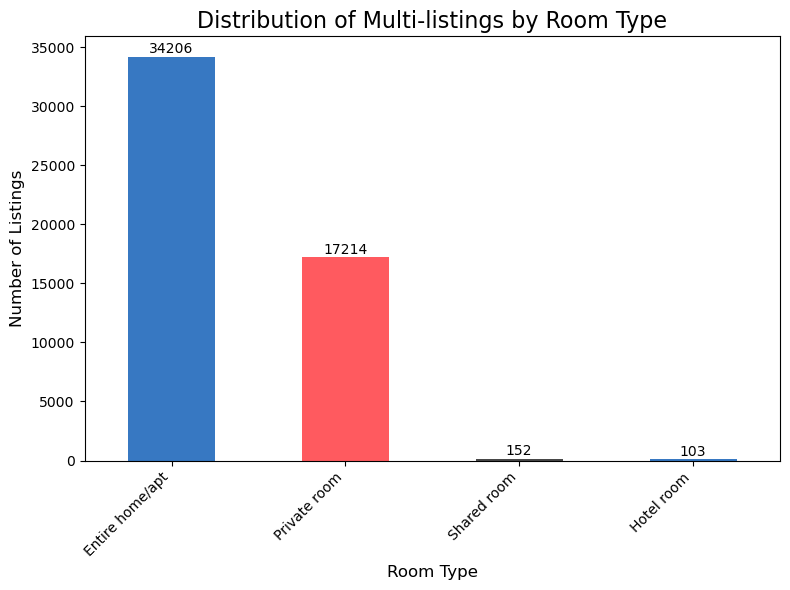

In [30]:
# multi-listing host
room_type_counts = df_multi_host['room_type'].value_counts()
plt.figure(figsize=(8, 6))
room_type_counts.sort_values(ascending=False).plot(kind='bar', color=['#3778c2', '#ff5a5f', '#484848'])
# Add title and labels
plt.title('Distribution of Multi-listings by Room Type', fontsize=16)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add the counts on top of the bars for exact values
for i, count in enumerate(room_type_counts.sort_values(ascending=False)):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()

# Save the plot
#plt.savefig('room_type_distribution_bar_chart.png')
#plt.close()

print("Room Type Distribution (Counts):\n", room_type_counts)
print("\nBar chart saved as room_type_distribution_bar_chart.png")

In [31]:
# Calculate the raw counts of each room_type in the multi-host group
room_type_counts = df_multi_host['room_type'].value_counts()

# Calculate the percentage distribution
# normalize=True makes the result a percentage (sum of 1.0)
room_type_percentages = df_multi_host['room_type'].value_counts(normalize=True) * 100

print("--- Room Type Distribution for Multi-Listing Landlords ---")
print("\n1. Raw Counts:")
print(room_type_counts)
print("\n2. Percentage Distribution:")
print(room_type_percentages.round(2).astype(str) + '%')

--- Room Type Distribution for Multi-Listing Landlords ---

1. Raw Counts:
room_type
Entire home/apt    34206
Private room       17214
Shared room          152
Hotel room           103
Name: count, dtype: int64

2. Percentage Distribution:
room_type
Entire home/apt    66.19%
Private room       33.31%
Shared room         0.29%
Hotel room           0.2%
Name: proportion, dtype: object


Our main concern is how to define the identification of host with multiple private rooms or shared rooms. Are they professional landlords?

To robust our analysis, we take further step to investigate the `description`. Under the comparision wiht "Entire home/apt" and "Hotel room", we want to know if there are many similar descriptions from "Private room", "Shared room", which indicats commercial usage.

In [132]:
# ### text analysis
# '''
# tried to use this code, but failed
# '''
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

# df['description'] = df['description'].fillna('')

# # --- 1. SEGMENTATION & VECTORIZATION ---

# # Create masks for the three groups we want to compare
# is_entire = (df['room_type'] == 'Entire home/apt')
# is_private = (df['room_type'] == 'Private room')
# is_shared = (df['room_type'] == 'Shared room')
# is_candidate = is_private | is_shared

# # 1.1. Prepare the descriptions for vectorization
# # We must vectorize the entire dataset together to ensure a consistent feature set (vocabulary).
# all_descriptions = df['description'].tolist()

# # 1.2. Initialize and fit the vectorizer
# vectorizer = TfidfVectorizer(
#     stop_words='english',
#     max_features=2000,     # Increased features for better language nuance
#     ngram_range=(1, 2)
# )

# # Fit the vectorizer and transform ALL descriptions into the TF-IDF matrix
# tfidf_matrix = vectorizer.fit_transform(all_descriptions)


# # --- 2. CALCULATE THE REFERENCE PROFILE (Entire Home) ---

# # 2.1. Extract vectors for Entire Home listings
# entire_vectors = tfidf_matrix[is_entire.values]

# # 2.2. Calculate the average vector for the Entire Home group
# # This is the "average commercial language profile"
# entire_reference_vector = entire_vectors.mean(axis=0)
# entire_reference_vector_dense = entire_reference_vector.getA().flatten()


# # --- 3. CALCULATE SIMILARITY FOR CANDIDATE LISTINGS ---

# # 3.1. Extract vectors for the Private/Shared candidate listings
# candidate_vectors = tfidf_matrix[is_candidate]

# # 3.2. Get the host IDs for matching the scores back to the original DataFrame
# candidate_indices = df[is_candidate].index

# # 3.3. Calculate Cosine Similarity:
# # We compare every candidate vector (row in candidate_vectors) against the single reference vector.
# similarity_scores = cosine_similarity(candidate_vectors, entire_reference_vector)

# # Flatten the result and map it back to the DataFrame
# similarity_series = pd.Series(similarity_scores.flatten(), index=candidate_indices)
# df['entire_similarity_score'] = 0.0 # Initialize column

# df.loc[candidate_indices, 'entire_similarity_score'] = similarity_series

# # --- 4. APPLY THRESHOLD & RECLASSIFY ---

# # **CRITICAL DECISION:** You must choose a threshold. A good starting point is the 90th percentile
# # of similarity scores among the Private/Shared listings.
# similarity_threshold = df.loc[is_candidate, 'entire_similarity_score'].quantile(0.90)

# print(f"Similarity Threshold for Commercial Classification (90th percentile): {similarity_threshold:.4f}")

# # Flag listings with high similarity as linguistically commercial
# is_ling_commercial = df['entire_similarity_score'] >= similarity_threshold


# # --- 5. RECALCULATE PROFESSIONAL LANDLORDS ---

# # A. Base Commercial (Intent & Scale)
# is_entire_multi = (df['room_type'] == 'Entire home/apt') & (df['listing_count'] > 1)
# is_hotel = (df['room_type'] == 'Hotel room')

# # B. Refined Professional Filter: Add the high-similarity shared units
# is_professional_listing_refined = is_entire_multi | is_hotel | is_ling_commercial

# # Filter and count
# df_landlord_refined = df[is_professional_listing_refined].copy()
# num_landlords_refined = df_landlord_refined['host_id'].nunique()
# num_properties_refined = df_landlord_refined.shape[0]

# print("\n--- Final Refined Professional Landlord Count ---")
# print(f"Total Unique Professional Landlords: {num_landlords_refined:,}")
# print(f"Total Properties Managed by Refined Definition: {num_properties_refined:,}")
# print(f"Number of Private/Shared Listings added via Similarity: {is_ling_commercial.sum():,}")

Room Type Distribution (Counts):
 room_type
Entire home/apt    28250
Private room       16679
Shared room           39
Hotel room             8
Name: count, dtype: int64

Bar chart saved as room_type_distribution_bar_chart.png


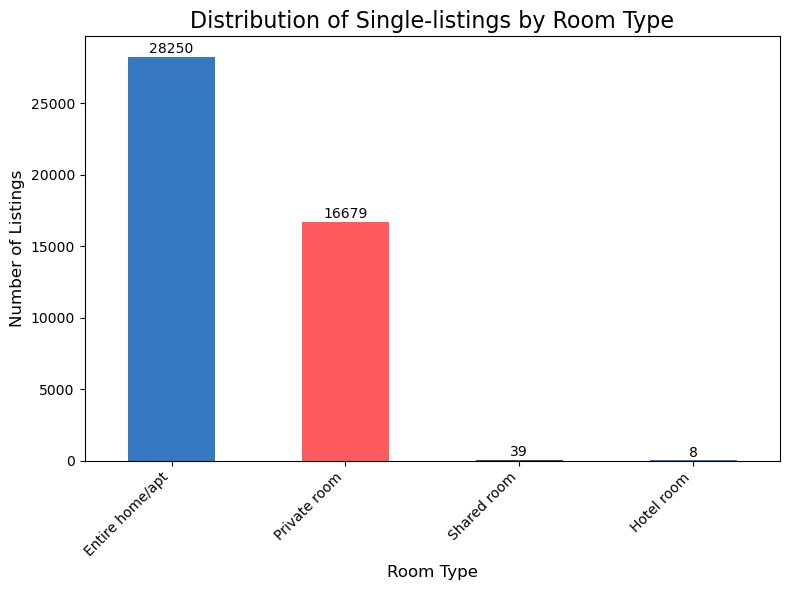

In [32]:
# single-listing host
room_type_counts = df_single_host['room_type'].value_counts()
plt.figure(figsize=(8, 6))
room_type_counts.sort_values(ascending=False).plot(kind='bar', color=['#3778c2', '#ff5a5f', '#484848'])
# Add title and labels
plt.title('Distribution of Single-listings by Room Type', fontsize=16)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add the counts on top of the bars for exact values
for i, count in enumerate(room_type_counts.sort_values(ascending=False)):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()

# Save the plot
#plt.savefig('room_type_distribution_bar_chart.png')
#plt.close()

print("Room Type Distribution (Counts):\n", room_type_counts)
print("\nBar chart saved as room_type_distribution_bar_chart.png")

In [33]:
# Calculate the raw counts of each room_type in the single-host group
room_type_counts = df_single_host['room_type'].value_counts()

# Calculate the percentage distribution
# normalize=True makes the result a percentage (sum of 1.0)
room_type_percentages = df_single_host['room_type'].value_counts(normalize=True) * 100

print("--- Room Type Distribution for Single-Listing Landlords ---")
print("\n1. Raw Counts:")
print(room_type_counts)
print("\n2. Percentage Distribution:")
print(room_type_percentages.round(2).astype(str) + '%')

--- Room Type Distribution for Single-Listing Landlords ---

1. Raw Counts:
room_type
Entire home/apt    28250
Private room       16679
Shared room           39
Hotel room             8
Name: count, dtype: int64

2. Percentage Distribution:
room_type
Entire home/apt    62.81%
Private room       37.08%
Shared room         0.09%
Hotel room          0.02%
Name: proportion, dtype: object


From plot and data results, we know there are 62.8% of single-listing is "Entire home/apt". This indicates a large propotion of a single "Entire home/apt" listing, which we could not ignore in terms of "professional property".

Based on analysis so far, we adjust our criteria as: a **"Professional Landlord,"** it must satisfy Criterion 1 (Scale) with new threshold of  `listing_count` $\geq 1$ AND its `room_type` must be one of the types selected by Criterion 2 (Intent).

--- 1. Professional Landlord Analysis ---
Total Unique Landlords: 55,804
Total number of Professional Landlords (Unique Host IDs): 35,953
Total number of Properties managed by these landlords: 62,567
Percentage of Professional Landlords: 64.43%
Percentage of Professional Properties: 64.73%

--- 2. Segmentation Summary ---
Total Multi-Host Listings (df_multi_host): 51,675
Total Single-Host Listings (df_single_host): 44,976


<Figure size 1000x600 with 0 Axes>

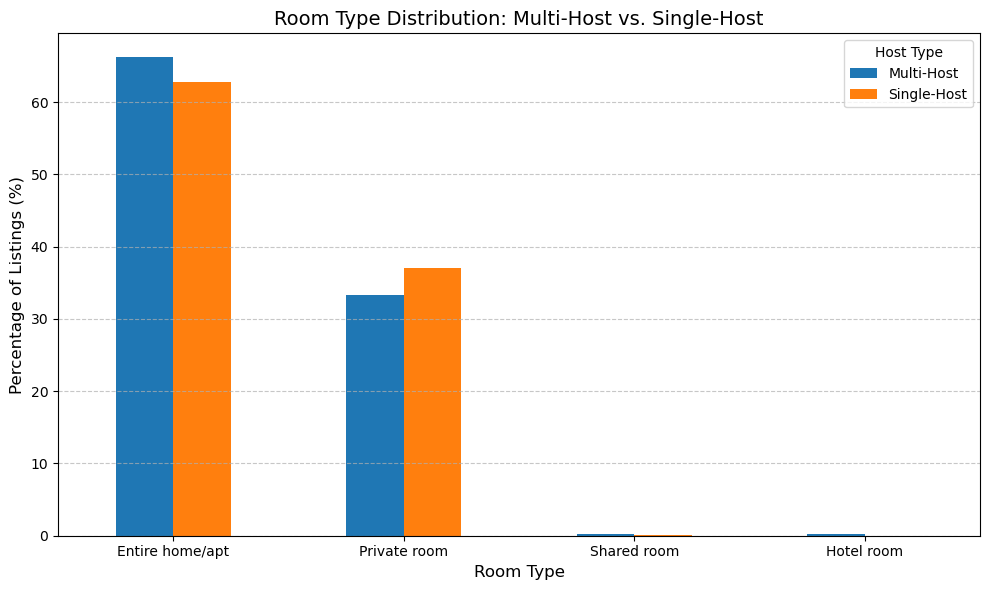


--- 3. Distribution Comparison (Percentage) ---
                 Multi-Host  Single-Host
room_type                               
Entire home/apt   66.194485    62.811277
Private room      33.312046    37.084223
Shared room        0.294146     0.086713
Hotel room         0.199323     0.017787


In [39]:
# Define the columns we'll be interested in throughout the analysis
COLUMNS_OF_INTEREST = [
    'host_id', 'id', 'room_type', 'property_type', 'calculated_host_listings_count'
]

## --- STAGE 1: CLASSIFICATION AND SEGMENTATION ---

# 1. Define the Professional Landlord Criteria (Intent and Scale)
is_entire_multi = (df['room_type'] == 'Entire home/apt') & (df['calculated_host_listings_count'] >= 1)
is_hotel = (df['room_type'] == 'Hotel room')
df['is_professional_listing'] = is_entire_multi | is_hotel


# --- 1.1. Create the Final Professional Landlord DF (df_landlord) ---

# Filter the main DF to keep ONLY the professional listings and select columns
df_professional = df[df['is_professional_listing']].copy()
df_landlord = df_professional[COLUMNS_OF_INTEREST]

# --- 1.2. Create Multi/Single Host DFs for Distribution Analysis ---

# Filter for Multi-Host Listings (Scale > 1)
df_multi_host = df[df['calculated_host_listings_count'] > 1].copy()
df_multi_host = df_multi_host[COLUMNS_OF_INTEREST]

# Filter for Single-Host Listings (Scale = 1)
df_single_host = df[df['calculated_host_listings_count'] == 1].copy()
df_single_host = df_single_host[COLUMNS_OF_INTEREST]


# --- STAGE 2: CALCULATION AND ANALYSIS ---

total_landlords = df['host_id'].nunique()
total_property = df.shape[0]

# 3. Final Calculation for Professional Landlords
num_professional_landlords = df_landlord['host_id'].nunique()
num_properties = df_landlord.shape[0]

if total_landlords > 0:
    professional_percentage = (num_professional_landlords / total_landlords) * 100
else:
    professional_percentage = 0.0

pro_property_percentage = (num_properties / total_property)*100

print("--- 1. Professional Landlord Analysis ---")
print(f"Total Unique Landlords: {total_landlords:,}")
print(f"Total number of Professional Landlords (Unique Host IDs): {num_professional_landlords:,}")
print(f"Total number of Properties managed by these landlords: {num_properties:,}")
print(f"Percentage of Professional Landlords: {professional_percentage:.2f}%")
print(f"Percentage of Professional Properties: {pro_property_percentage:.2f}%")

print("\n--- 2. Segmentation Summary ---")
print(f"Total Multi-Host Listings (df_multi_host): {df_multi_host.shape[0]:,}")
print(f"Total Single-Host Listings (df_single_host): {df_single_host.shape[0]:,}")


# --- STAGE 3: VISUALIZATION (Distribution Comparison) ---

# 4. Calculate the distribution for each group
multi_host_distribution = df_multi_host['room_type'].value_counts(normalize=True) * 100
single_host_distribution = df_single_host['room_type'].value_counts(normalize=True) * 100

# 5. Combine the distributions for plotting
comparison_df = pd.DataFrame({
    'Multi-Host': multi_host_distribution,
    'Single-Host': single_host_distribution
}).fillna(0)

# 6. Plot the side-by-side comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', figsize=(10, 6))

plt.title('Room Type Distribution: Multi-Host vs. Single-Host', fontsize=14)
plt.ylabel('Percentage of Listings (%)', fontsize=12)
plt.xlabel('Room Type', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Host Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 

print("\n--- 3. Distribution Comparison (Percentage) ---")
print(comparison_df)

--- 1. Professional Landlord Analysis ---
Total Unique Landlords: 55,804
Total number of Professional Landlords (Unique Host IDs): 35,953
Total number of Properties managed by these landlords: 62,567
Percentage of Professional Landlords: 64.43%
Percentage of Professional Properties: 64.73%

--- 2. Segmentation Summary ---
Total Multi-Host Listings (df_multi_host): 51,675
Total Single-Host Listings (df_single_host): 44,976


<Figure size 1000x600 with 0 Axes>

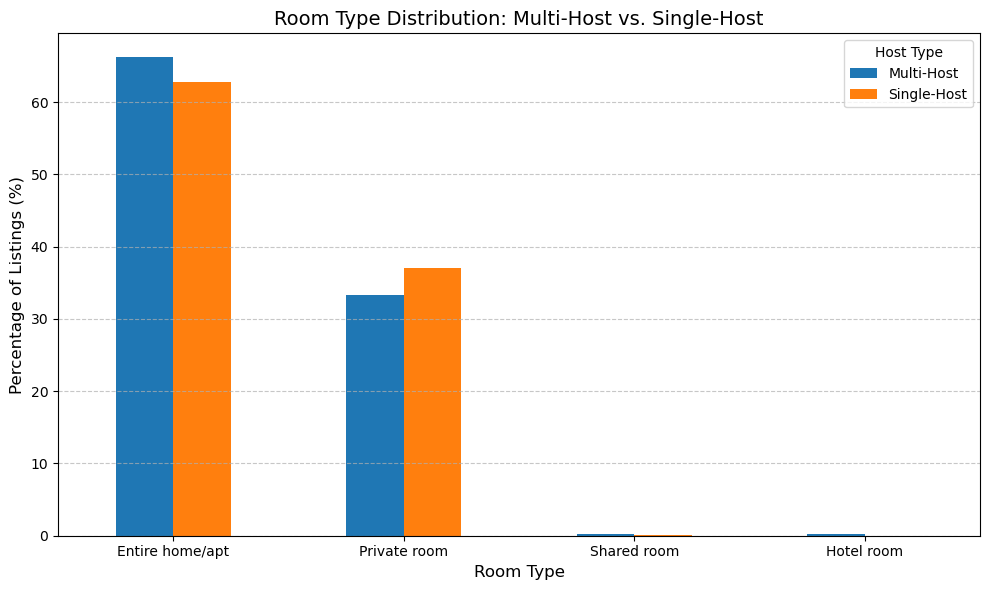


--- 3. Distribution Comparison (Percentage) ---
                 Multi-Host  Single-Host
room_type                               
Entire home/apt   66.194485    62.811277
Private room      33.312046    37.084223
Shared room        0.294146     0.086713
Hotel room         0.199323     0.017787


In [37]:
# Define the columns we'll be interested in throughout the analysis
COLUMNS_OF_INTEREST = [
    'host_id', 'id', 'room_type', 'property_type', 
    'listing_count', 'calculated_host_listings_count'
]

## --- STAGE 1: CLASSIFICATION AND SEGMENTATION ---

# 1. Calculate Scale: Determine how many listings each host has in the dataset.
df['listing_count'] = df.groupby('host_id')['id'].transform('count')

# 2. Define the Professional Landlord Criteria (Intent and Scale)
is_entire_multi = (df['room_type'] == 'Entire home/apt') & (df['listing_count'] >= 1)
is_hotel = (df['room_type'] == 'Hotel room')
df['is_professional_listing'] = is_entire_multi | is_hotel


# --- 2.1. Create the Final Professional Landlord DF (df_landlord) ---

# Filter the main DF to keep ONLY the professional listings and select columns
df_professional = df[df['is_professional_listing']].copy()
df_landlord = df_professional[COLUMNS_OF_INTEREST]

# --- 2.2. Create Multi/Single Host DFs for Distribution Analysis ---

# Filter for Multi-Host Listings (Scale > 1)
df_multi_host = df[df['listing_count'] > 1].copy()
df_multi_host = df_multi_host[COLUMNS_OF_INTEREST]

# Filter for Single-Host Listings (Scale = 1)
df_single_host = df[df['listing_count'] == 1].copy()
df_single_host = df_single_host[COLUMNS_OF_INTEREST]


# --- STAGE 2: CALCULATION AND ANALYSIS ---

total_landlords = df['host_id'].nunique()
total_property = df.shape[0]

# 3. Final Calculation for Professional Landlords
num_professional_landlords = df_landlord['host_id'].nunique()
num_properties = df_landlord.shape[0]

if total_landlords > 0:
    professional_percentage = (num_professional_landlords / total_landlords) * 100
else:
    professional_percentage = 0.0

pro_property_percentage = (num_properties / total_property)*100

print("--- 1. Professional Landlord Analysis ---")
print(f"Total Unique Landlords: {total_landlords:,}")
print(f"Total number of Professional Landlords (Unique Host IDs): {num_professional_landlords:,}")
print(f"Total number of Properties managed by these landlords: {num_properties:,}")
print(f"Percentage of Professional Landlords: {professional_percentage:.2f}%")
print(f"Percentage of Professional Properties: {pro_property_percentage:.2f}%")

print("\n--- 2. Segmentation Summary ---")
print(f"Total Multi-Host Listings (df_multi_host): {df_multi_host.shape[0]:,}")
print(f"Total Single-Host Listings (df_single_host): {df_single_host.shape[0]:,}")


# --- STAGE 3: VISUALIZATION (Distribution Comparison) ---

# 4. Calculate the distribution for each group
multi_host_distribution = df_multi_host['room_type'].value_counts(normalize=True) * 100
single_host_distribution = df_single_host['room_type'].value_counts(normalize=True) * 100

# 5. Combine the distributions for plotting
comparison_df = pd.DataFrame({
    'Multi-Host': multi_host_distribution,
    'Single-Host': single_host_distribution
}).fillna(0)

# 6. Plot the side-by-side comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', figsize=(10, 6))

plt.title('Room Type Distribution: Multi-Host vs. Single-Host', fontsize=14)
plt.ylabel('Percentage of Listings (%)', fontsize=12)
plt.xlabel('Room Type', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Host Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 

print("\n--- 3. Distribution Comparison (Percentage) ---")
print(comparison_df)

### 1.3 Create Geo-Data Frame

The current data we have is not Geo-Data yet, since the data represents points and is provided with latitude and longitude (or similar) as separate columns in a non-geographic data set. Therefore, we need to convert our coordinates into some kind of geo-data with `GeoPandas` package.

In [43]:
# Write data into Geo-data and
# set the crs into '4326'
gdf = gpd.GeoDataFrame(df,
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

In [44]:
# We check types of dataframes 
print(type(gdf))
print(type(gdf.geometry))
print(gdf.geometry.iloc[:5])

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
0    POINT (-0.01948 51.44306)
1    POINT (-0.01997 51.44284)
2    POINT (-0.02275 51.44359)
3    POINT (-0.02309 51.44355)
4    POINT (-0.02307 51.44333)
Name: geometry, dtype: geometry


In [45]:
## q1:
## out of control: letting entire property

## q2:
## over 50% are professional landlords
## entire property? individual rooms in many buildings
## in description: shared rooms with other tourists - illegal if landlord is absent 

In [47]:
# import pandas as pd
# import re
# import matplotlib.pyplot as plt

# from bs4 import BeautifulSoup

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

# # We don't use this but I point out where you *could*
# from sklearn.preprocessing import OneHotEncoder 

In [48]:
# # 分词器和lemmatizer
# !pip install nltk
# import nltk

# try:
#     from nltk.corpus import wordnet as wn
#     from nltk.stem.wordnet import WordNetLemmatizer
#     from nltk.corpus import stopwords
#     stopwords.words('english')
#     lemmatizer = WordNetLemmatizer()
#     tokenizer = ToktokTokenizer()
# except:
#     nltk.download("stopwords")
#     nltk.download("punkt_tab")
#     nltk.download("averaged_perceptron_tagger_eng")
#     from nltk.corpus import stopwords
#     from nltk.corpus import wordnet as wn
#     from nltk.stem.wordnet import WordNetLemmatizer
#     stopwords.words('english')

# from nltk.corpus import stopwords
# stopword_list = set(stopwords.words('english'))

# from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.tokenize.toktok import ToktokTokenizer

# from nltk.stem.porter import PorterStemmer
# from nltk.stem.snowball import SnowballStemmer

# from nltk import ngrams, FreqDist

# lemmatizer = WordNetLemmatizer()
# tokenizer = ToktokTokenizer()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [40]:
# analysing text similarity between pro/non_pro
# group_by
df_group_by_type = df.groupby('room_type')

cols_str_detect = ['host_id', 'room_type', 'description']
str_detect = df_group_by_type[cols_str_detect]

str_detect.head()

# 定义区分筛选条件：分为valid/invalid pro
valid_hosts = df[df['room_type'].isin(['Entire home/apt', 'Hotel room'])]['host_id'].unique()
invalid_hosts = df[~df['host_id'].isin(valid_hosts)]['host_id'].unique()
invalid_hosts = [h for h in invalid_hosts if (df['host_id'] == h).sum() > 1]

str_entire_home = df_group_by_type.get_group('Entire home/apt')[cols_str_detect]
str_hotel_room = df_group_by_type.get_group('Hotel room')[cols_str_detect]
str_shared_room = df_group_by_type.get_group('Shared room')[cols_str_detect]
str_private_room = df_group_by_type.get_group('Private room')[cols_str_detect]

# 用host_id是否valid过滤（避免index变动造成的影响）
str_entire_hotel = pd.concat(
    [
        str_entire_home[str_entire_home['host_id'].isin(valid_hosts)],
        str_hotel_room[str_hotel_room['host_id'].isin(valid_hosts)]
    ],
    ignore_index=True
)

print(str_entire_hotel.head())


str_shared_private = pd.concat(
    [
        str_shared_room[str_shared_room['host_id'].isin(invalid_hosts)],
        str_private_room[str_private_room['host_id'].isin(invalid_hosts)]
    ],
    ignore_index=True
)

print(str_shared_private.head())


/tmp/ipykernel_104/1154336495.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_group_by_type = df.groupby('room_type')


   host_id        room_type                                        description
0  1389063  Entire home/apt  An extremely large and sunny four bedroom grou...
1  1389063  Entire home/apt  Recently refurbished sunny one bedroom first f...
2  1389063  Entire home/apt  A large and sunny two bedroom second floor apa...
3  1389063  Entire home/apt  A large and sunny two bedroom second floor apa...
4  1389063  Entire home/apt  Completely refurbished 2 bedroom apt to sleep ...
     host_id    room_type                                        description
0   34771444  Shared room  This is a bright double room within a new buil...
1   88569660  Shared room  My place is in central London E1, close to Tow...
2   24960812  Shared room  The 4 bedroom house has two rooms for guest ro...
3   45363496  Shared room  Enjoy easy access to popular shops and restaur...
4  303622628  Shared room  Light bright freshly decorated room within a l...


In [42]:
valid_hosts

array([  1389063,   1416605,   2011372, ..., 593071335, 260931753,
       698200683], shape=(35953,))

In [43]:
invalid_hosts

[np.int64(157884),
 np.int64(1442674),
 np.int64(1517741),
 np.int64(188138),
 np.int64(1950992),
 np.int64(335716),
 np.int64(2231552),
 np.int64(1599044),
 np.int64(766056),
 np.int64(2098510),
 np.int64(1995157),
 np.int64(492218),
 np.int64(1950414),
 np.int64(2074557),
 np.int64(1438723),
 np.int64(2354821),
 np.int64(1688557),
 np.int64(1703080),
 np.int64(704495),
 np.int64(2398949),
 np.int64(2413601),
 np.int64(1734105),
 np.int64(1969324),
 np.int64(1745432),
 np.int64(1763100),
 np.int64(2489676),
 np.int64(1775224),
 np.int64(968464),
 np.int64(2526516),
 np.int64(2534693),
 np.int64(1023326),
 np.int64(448365),
 np.int64(1269568),
 np.int64(1810850),
 np.int64(1836808),
 np.int64(2553226),
 np.int64(2672153),
 np.int64(2565699),
 np.int64(2531619),
 np.int64(1890206),
 np.int64(2594885),
 np.int64(2605151),
 np.int64(2608240),
 np.int64(1941593),
 np.int64(1952645),
 np.int64(3467954),
 np.int64(1955705),
 np.int64(1958174),
 np.int64(3511295),
 np.int64(1237006),
 np.int6

In [ ]:
# import re

# cleaned = str_entire_hotel['description'].fillna("").apply(lambda x: BeautifulSoup(x, 'html.parser').get_text(" "))
# lower = cleaned.str.lower()

# # clean 标点特殊符号多余符号和emoji
# pat = re.compile(r'[^a-z0-9\s]')
# subbed = lower.apply(lambda x: pat.sub('', x))


In [ ]:
# nltk.download('punkt')
# nltk.download('wordnet')
# from nltk.tokenize import word_tokenize
# tokens = lower.apply(word_tokenize)
# tokens


# from nltk.stem.porter import PorterStemmer
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem.wordnet import WordNetLemmatizer 

# lemmatizer = WordNetLemmatizer()

# lemmas = tokens.apply(lambda x: [lemmatizer.lemmatize(t) for t in x])

# '''
# as_markdown("Lemmatised", '\n\n>'.join(lemmas.str.join(' ').to_list()))
# # 这里print会全出来，不必要时先不print。。。

# print("\n\n")

# '''


In [ ]:
# stopword_list = set(stopwords.words('english'))
# print(stopword_list)

# tokens = tokens.apply(lambda lst: [x for x in lst if x not in stopword_list and len(x)>1])


In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
# try: 
#     from textual import *
# except:
#     try:
#         from unidecode import unidecode
#     except:
#         ! pip install unidecode
#     import urllib.request
#     host  = 'https://orca.casa.ucl.ac.uk'
#     turl  = f'{host}/~jreades/__textual__.py'
#     tdirs = Path('textual')
#     tpath = Path(tdirs / '__init__.py')

#     if not tpath.exists():
#         tdirs.mkdir(parents=True, exist_ok=True)
#         urllib.request.urlretrieve(turl, tpath)
#     from textual import *

In [ ]:
# str_entire_hotel['description'] = tokens.apply(normalise_document, remove_digits=True)

# srcdf = str_entire_hotel['description']

# corpus = srcdf.fillna(" ").values
# print(corpus[0:3])

# # 下面这部分没啥用，practice里有的但是是另外的示例，我们这里做用不到
# '''
# sentences = [nltk.sent_tokenize(text) for text in corpus]
# words     = [[nltk.tokenize.word_tokenize(sentence) 
#                   for sentence in nltk.sent_tokenize(text)] 
#                   for text in corpus]

# print(f"Sentences 0: {sentences[0]}")
# print()
# print(f"Words 0: {words[0]}")
# '''

In [ ]:
# # 前面的清理步骤建议直接写成一个函数，有用的基本就是这些，更直观，可以直接用，如下：
# # str_shared_private['description_clean'] = clean_text(str_shared_private['description'])


# def clean_text(text):
#     cleaned = text.fillna("").apply(lambda x: BeautifulSoup(x, 'html.parser').get_text(" "))
#     lower = cleaned.str.lower()
#     pat = re.compile(r'[^a-z0-9\s]')
#     no_punct = lower.apply(lambda x: pat.sub('', x))
#     tokens = lower.apply(word_tokenize)
#     tokens = tokens.apply(lambda x: [lemmatizer.lemmatize(t) for t in x])
#     tokens = tokens.apply(lambda lst: [x for x in lst if x not in stopword_list])
#     normalised = tokens.apply(normalise_document, remove_digits=True)
#     normalised_str = normalised.apply(lambda lst: ' '.join(lst))
#     return normalised_str

In [ ]:
# fcounts = dict()

# data = nltk.tokenize.word_tokenize(
#     ' '.join([str(text).replace('.', '') for text in corpus])
# )


# for size in 1, 2, 3:
#     fdist = FreqDist(ngrams(data, size))
#     print(fdist)
#     fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})


In [ ]:
# for dfs in fcounts.values():
#     print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))
#     print()

In [ ]:

# from sklearn.feature_extraction.text import CountVectorizer

# corpus = [str(x) for x in corpus]
# cvectorizer = CountVectorizer()
# cvectorizer.fit(corpus)
# pd.options.display.max_colwidth=750



# cvtcorpus = cvectorizer.transform(corpus)
# cvtcorpus # cvtcorpus for count-vectorised transformed corpus

# doc_df = pd.DataFrame(cvtcorpus[0].T.todense(), 
#                       index=cvectorizer.get_feature_names_out(), columns=["Counts"]
#                      ).sort_values('Counts', ascending=False)
# doc_df.head(50)


# cvdf = pd.DataFrame(data=cvtcorpus.toarray(),
#                         columns=cvectorizer.get_feature_names_out())
# print(f"Raw count vectorised data frame has {cvdf.shape[0]:,} rows and {cvdf.shape[1]:,} columns.")
# cvdf.iloc[0:3,0:7]


# sums = cvdf.sum(axis=0)
# print(f"There are {len(sums):,} terms in the data set.")
# sums.head()

# filter_terms = sums >= cvdf.shape[0] * 0.01
# fcvdf = cvdf.drop(columns=cvdf.columns[~filter_terms].values)
# print(f"Filtered count vectorised data frame has {fcvdf.shape[0]:,} rows and {fcvdf.shape[1]:,} columns.")
# fcvdf.iloc[0:3,0:7]
# fcvdf.sum(axis=0)

In [ ]:
# # 


# # str_detect
# from sklearn.feature_extraction.text import TfidfVectorizer
# import numpy as np
# import re

# # n-gram + TF-IDF identifyer
# vectorizer = TfidfVectorizer(
#     ngram_range = (1, 3),   # unigram + bigram + trigram
#     max_df = 0.95,          # drop words which occured in 95%+ listings
#     min_df = 0.0005,         
#     stop_words = 'english'
# )

# tfidf_matrix = vectorizer.fit_transform(corpus)

# feature_names = np.array(vectorizer.get_feature_names_out())
# avg_tfidf = tfidf_matrix.mean(axis=0).A1  # 计算每列平均值
# tfidf_df = pd.DataFrame({'ngram': feature_names, 'avg_tfidf': avg_tfidf})

# # rank based on TF-IDF mean value，get top 50 words
# top_ngrams = tfidf_df.sort_values(by='avg_tfidf', ascending=False).head(52)
# print(top_ngrams)

In [ ]:
# # delete outliers

# top_ngrams = top_ngrams[~top_ngrams['ngram'].str.contains(r'\bbr\b')]
# print(top_ngrams)

In [ ]:
# # calculate similarity (on shared/private listings)

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

# top_keywords = list(top_ngrams['ngram'])
# top_keywords_set = set(top_keywords)

# str_shared_private['description'] = str_shared_private['description'].fillna('').astype(str)
# str_shared_private['description'] = clean_text(str_shared_private['description'])

# # method: jaccard
# # 这个方法只词频不加权重，cosine的也看权重，这里两个结合作为判断标准。一般来说cosine即可
# def jaccard_similarity(text):
#     words = set(text.split())
#     if not words:
#         return 0
#     intersection = words & top_keywords_set
#     union = words | top_keywords_set
#     return len(intersection) / len(union)


# str_shared_private['jaccard_sim'] = str_shared_private['description'].apply(jaccard_similarity)


# vectorizer = TfidfVectorizer(vocabulary=top_keywords)
# X_unknown = vectorizer.fit_transform(str_shared_private['description'])


# top_vec = np.ones((1, len(top_keywords)))
# top_vec = top_vec / np.linalg.norm(top_vec)

# # method: cosine
# cos_sim = cosine_similarity(X_unknown, top_vec)
# str_shared_private['tfidf_cos_sim'] = cos_sim[:, 0]

# # tail(top n% similarity, n can be reset)
# jaccard_thresh = str_shared_private['jaccard_sim'].quantile(0.90)
# cosine_thresh = str_shared_private['tfidf_cos_sim'].quantile(0.90)


# high_sim_entries = str_shared_private[
#     (str_shared_private['jaccard_sim'] >= jaccard_thresh) &
#     (str_shared_private['tfidf_cos_sim'] >= cosine_thresh)
# ]

# print(high_sim_entries[['description', 'jaccard_sim', 'tfidf_cos_sim']])

In [48]:
print(spath+'Greenspace.gpkg?raw=true')

https://github.com/jreades/fsds/blob/master/data/src/Greenspace.gpkg?raw=true


In [44]:
# drawing distribution maps (pro/non-pro)
import geopandas as gpd

ddir  = Path('data/geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath + 'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath + 'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath + 'Greenspace.gpkg?raw=true', ddir) )

print('Done.')


+ data/geo/Boroughs.gpkg?raw=true found locally!
+ data/geo/Water.gpkg?raw=true found locally!
+ data/geo/Greenspace.gpkg?raw=true found locally!
Done.


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Boroughs.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Water.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Greenspace.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(


In [199]:
boros = boros.to_crs(epsg=4326)
print(f"The bottom-left corner is {boros.total_bounds[0]:.1f}, {boros.total_bounds[1]:.1f}")
print(f"The top-right corner is {boros.total_bounds[2]:.1f}, {boros.total_bounds[3]:.1f}")

gdf = gdf.to_crs(epsg=27700) # There is no 'in_place=True' option here.
print(gdf.geometry.crs)
print(gdf.total_bounds)
boros.info()

The bottom-left corner is -0.5, 51.3
The top-right corner is 0.3, 51.7
EPSG:27700
[504245.30944406 157333.4670249  556745.73529377 199941.4610359 ]
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        33 non-null     object  
 1   GSS_CODE    33 non-null     object  
 2   HECTARES    33 non-null     float64 
 3   NONLD_AREA  33 non-null     float64 
 4   ONS_INNER   33 non-null     object  
 5   geometry    33 non-null     geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 1.7+ KB


In [200]:
cols_mapping = ['id', 'host_id', 'host_name', 
                 'room_type', 'price', 
                'latitude', 'longitude', 'neighbourhood_cleansed', 
                'host_total_listings_count'
               ]

map_entire_home = df_group_by_type.get_group('Entire home/apt')[cols_mapping]
map_hotel_room = df_group_by_type.get_group('Hotel room')[cols_mapping]
map_shared_room = df_group_by_type.get_group('Shared room')[cols_mapping]
map_private_room = df_group_by_type.get_group('Private room')[cols_mapping]

print(map_private_room.head())


map_entire_hotel = str_entire_hotel = pd.concat(
    [
        map_entire_home[str_entire_home['host_id'].isin(valid_hosts)],
        map_hotel_room[str_hotel_room['host_id'].isin(valid_hosts)]
    ],
    ignore_index=True
)

map_single_private = str_entire_hotel = pd.concat(
    [
        map_shared_room[str_shared_room['host_id'].isin(valid_hosts)],
        map_private_room[str_private_room['host_id'].isin(valid_hosts)]
    ],
    ignore_index=True
)

        id  host_id host_name     room_type  price  latitude  longitude  \
9   266037  1395281     James  Private room   62.0  51.52617   -0.13020   
10  268398   979363   Donovan  Private room   66.0  51.50287   -0.10937   
12  271122  1419096   Claudia  Private room    NaN  51.53097   -0.39891   
16  427229  2087745      Tony  Private room    NaN  51.47574    0.05733   
20  427936  2126954    Carmen  Private room   70.0  51.54544   -0.07344   

   neighbourhood_cleansed  host_total_listings_count  
9                  Camden                        3.0  
10                Lambeth                        7.0  
12             Hillingdon                        4.0  
16              Greenwich                        2.0  
20                Hackney                        2.0  


In [201]:
from shapely.geometry import Point

for gdf in [boros, water, green]:
    gdf.to_crs(epsg=27700, inplace=True)


for name, df in zip(
    ['map_entire_home', 'map_hotel_room', 'map_shared_room', 'map_private_room'],
    [map_entire_home, map_hotel_room, map_shared_room, map_private_room]
):
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    df_geo = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
    df_geo.to_crs(epsg=27700, inplace=True)

    globals()[name] = df_geo


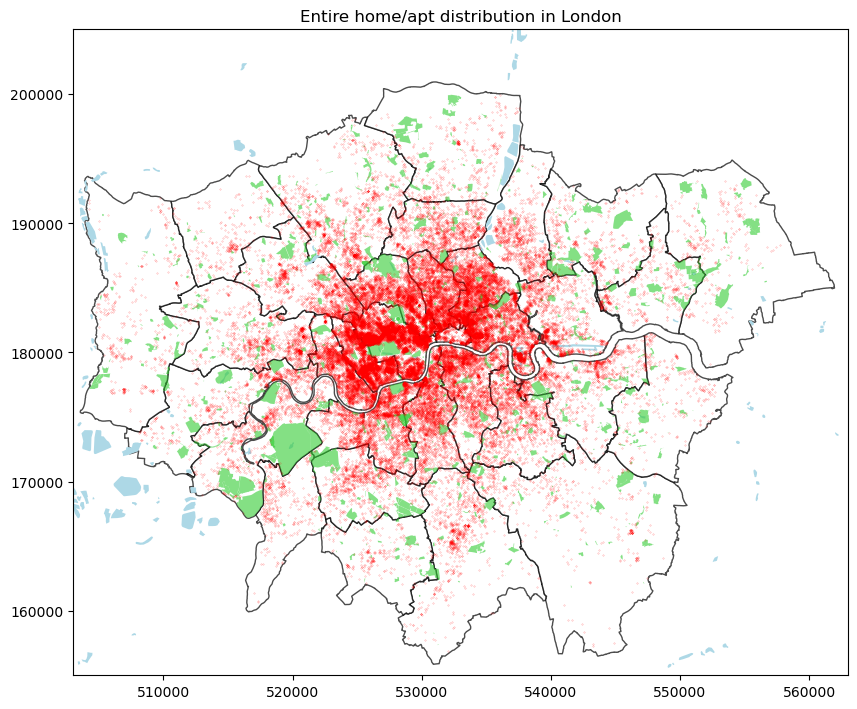

In [202]:
#distribution map
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

boros.plot(
    ax=ax,
    color='white',    # fill
    edgecolor='black',    # edge
    linewidth=1,        
    alpha=0.7             
)
water.plot(facecolor='lightblue',   
           ax=ax)
green.plot(facecolor=(0.2, 0.8, 0.2),     
           ax=ax, 
           alpha=0.6 )

map_entire_home.plot(ax=ax, color='red', markersize=0.05, alpha=0.5)

# trim
ax.set_xlim(503000, 563000)
ax.set_ylim(155000, 205000)

ax.set_aspect('equal')

ax.set_title('Entire home/apt distribution in London')
plt.show()



In [203]:
print(boros.crs)
print(map_entire_home.crs)
print(boroughs.geometry.type.value_counts())

EPSG:27700
EPSG:27700
MultiPolygon    33
Name: count, dtype: int64


<Axes: >

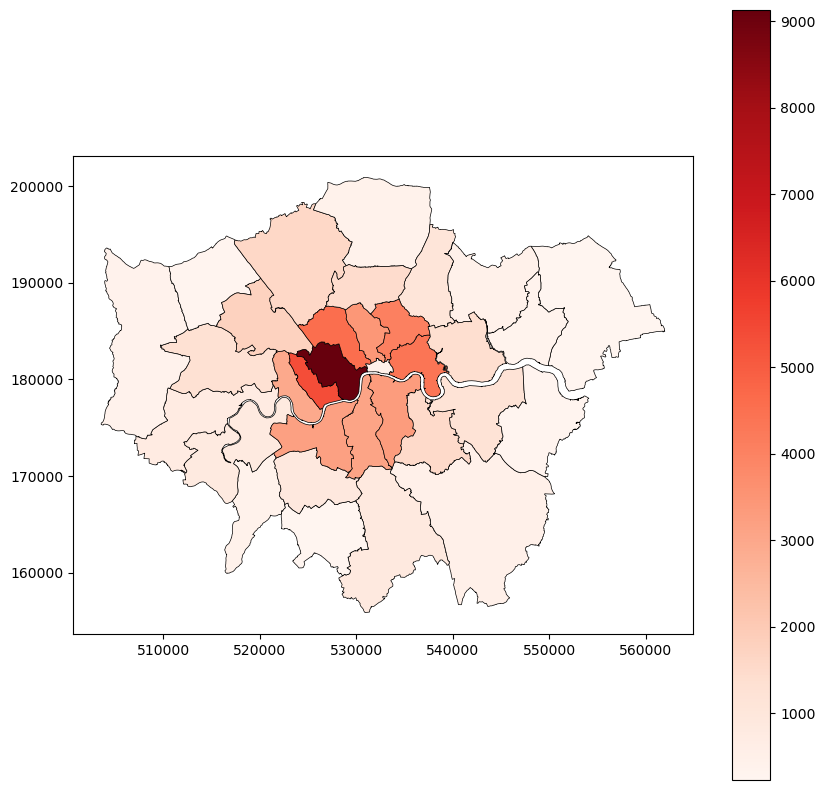

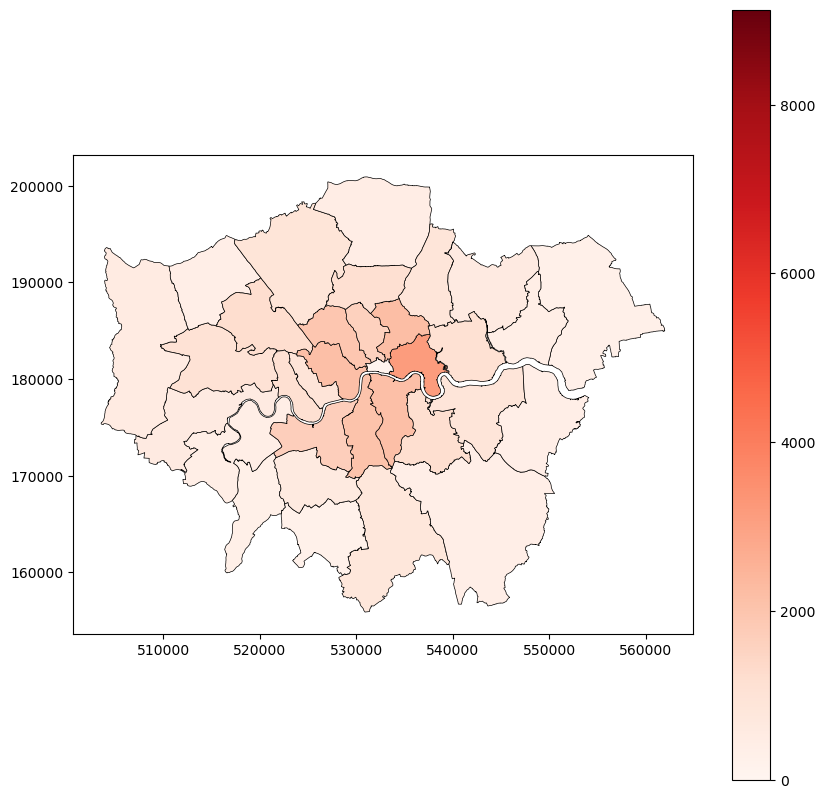

In [204]:
# density map

map_entire_home_boro = gpd.sjoin(
    map_entire_home,
    boros,
    how='left',
    predicate='within'   
)

# counting listings in each boro
counts = map_entire_home_boro.groupby('NAME').size()
boros['count_entire'] = boros['NAME'].map(counts).fillna(0)


# set legend scale
vmax = boros['count_entire'].max()


boros.plot(
    column='count_entire',
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    figsize=(10,10)
)

map_private_home_boro = gpd.sjoin(
    map_private_room,
    boros,
    how='left',
    predicate='within'   
)

counts = map_private_home_boro.groupby('NAME').size()
boros['count_private'] = boros['NAME'].map(counts).fillna(0)

boros.plot(
    column='count_private',
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    vmin=0,
    vmax=vmax,
    figsize=(10,10)
)

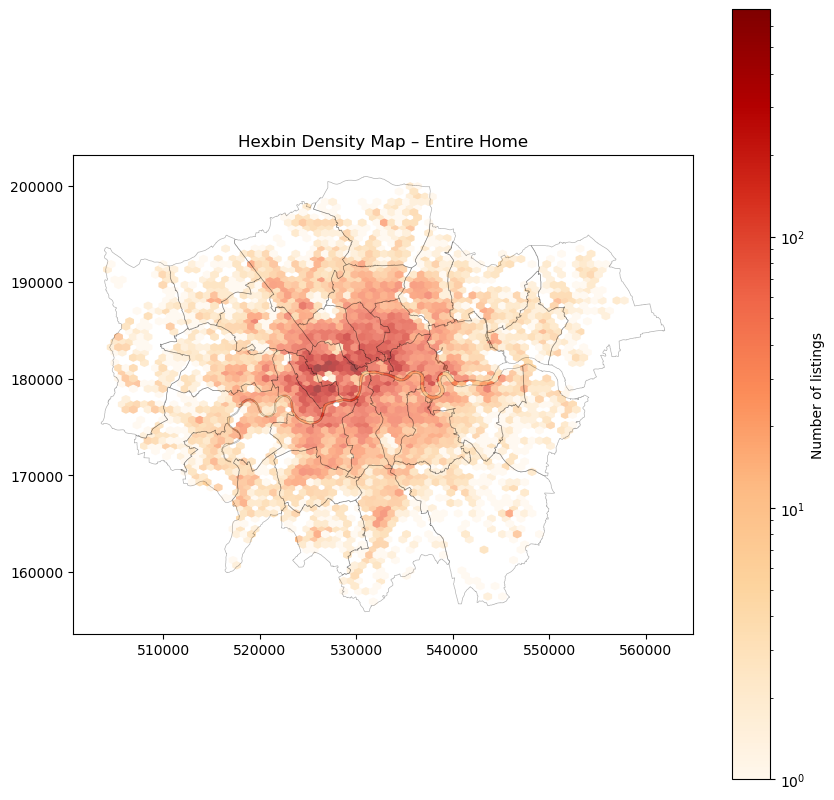

In [205]:
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(10, 10))


hb = ax.hexbin(
    map_entire_home['geometry'].x,
    map_entire_home['geometry'].y,
    gridsize=70,        # number of grids
    mincnt=1,        
    cmap='OrRd',
    norm=colors.LogNorm()
)


boros.plot(
    ax=ax,
    color='white',        # fill
    edgecolor='black',    # edge
    linewidth=0.5,        
    alpha=0.3             
)


ax.set_aspect('equal')

cb = fig.colorbar(hb, ax=ax)
cb.set_label("Number of listings")

ax.set_title("Hexbin Density Map – Entire Home")
plt.show()


In [206]:
# Dwelling dat


dwl = pd.read_csv("RM204-2021-1-filtered-2025-12-02T17-06-33Z.csv")
print(dwl.head())


dwl.columns = (
    dwl.columns
      .str.strip()        # 去前后空格
      .str.lower()        # 全部小写
      .str.replace(" ", "_")  # 空格变 _
      .str.replace(r"[^a-z0-9_]", "", regex=True)  # 去除特殊字符
)

dwl.head()


  Lower tier local authorities Code Lower tier local authorities  Observation
0                         E09000001               City of London         7323
1                         E09000002         Barking and Dagenham        76956
2                         E09000003                       Barnet       156147
3                         E09000004                       Bexley        99312
4                         E09000005                        Brent       127861


,lower_tier_local_authorities_code,lower_tier_local_authorities,observation
0,E09000001,City of London,7323
1,E09000002,Barking and Dagenham,76956
2,E09000003,Barnet,156147
3,E09000004,Bexley,99312
4,E09000005,Brent,127861


In [207]:

boro_entire_hotel = pd.concat([
    df_group_by_type.get_group('Entire home/apt'),
    df_group_by_type.get_group('Hotel room')
])


df_group_by_boro = (
    boro_entire_hotel['neighbourhood_cleansed']
      .value_counts()
      .reset_index()
)

df_group_by_boro.columns = ['neighbourhood_cleansed', 'listing_count']

print(df_group_by_boro.head())

   neighbourhood_cleansed  listing_count
0             Westminster           9157
1  Kensington and Chelsea           5398
2                  Camden           4576
3           Tower Hamlets           4403
4                 Hackney           4086


In [208]:
merged = dwl.merge(
    df_group_by_boro, 
    left_on="lower_tier_local_authorities",
    right_on="neighbourhood_cleansed",
    how="left"
)

merged.head()

,lower_tier_local_authorities_code,lower_tier_local_authorities,observation,neighbourhood_cleansed,listing_count
0,E09000001,City of London,7323,City of London,500
1,E09000002,Barking and Dagenham,76956,Barking and Dagenham,361
2,E09000003,Barnet,156147,Barnet,1592
3,E09000004,Bexley,99312,Bexley,285
4,E09000005,Brent,127861,Brent,1773


In [209]:
merged = merged.drop(columns=["neighbourhood_cleansed"])

merged.head(33)

,lower_tier_local_authorities_code,lower_tier_local_authorities,observation,listing_count
0,E09000001,City of London,7323,500
1,E09000002,Barking and Dagenham,76956,361
2,E09000003,Barnet,156147,1592
3,E09000004,Bexley,99312,285
4,E09000005,Brent,127861,1773
5,E09000006,Bromley,142083,496
6,E09000007,Camden,108236,4576
7,E09000008,Croydon,162273,877
8,E09000009,Ealing,142126,1328
9,E09000010,Enfield,128056,440


In [218]:

merged['rate'] = merged['listing_count'] / merged['observation']


merged['rate_pct'] = merged['rate'] * 100

merged.head(33)

,lower_tier_local_authorities_code,lower_tier_local_authorities,observation,listing_count,rate,rate_pct
0,E09000001,City of London,7323,500,0.068278,6.827803
1,E09000002,Barking and Dagenham,76956,361,0.004691,0.469099
2,E09000003,Barnet,156147,1592,0.010196,1.019552
3,E09000004,Bexley,99312,285,0.002870,0.286974
4,E09000005,Brent,127861,1773,0.013867,1.386662
5,E09000006,Bromley,142083,496,0.003491,0.349092
6,E09000007,Camden,108236,4576,0.042278,4.227799
7,E09000008,Croydon,162273,877,0.005404,0.540447
8,E09000009,Ealing,142126,1328,0.009344,0.934382
9,E09000010,Enfield,128056,440,0.003436,0.343600


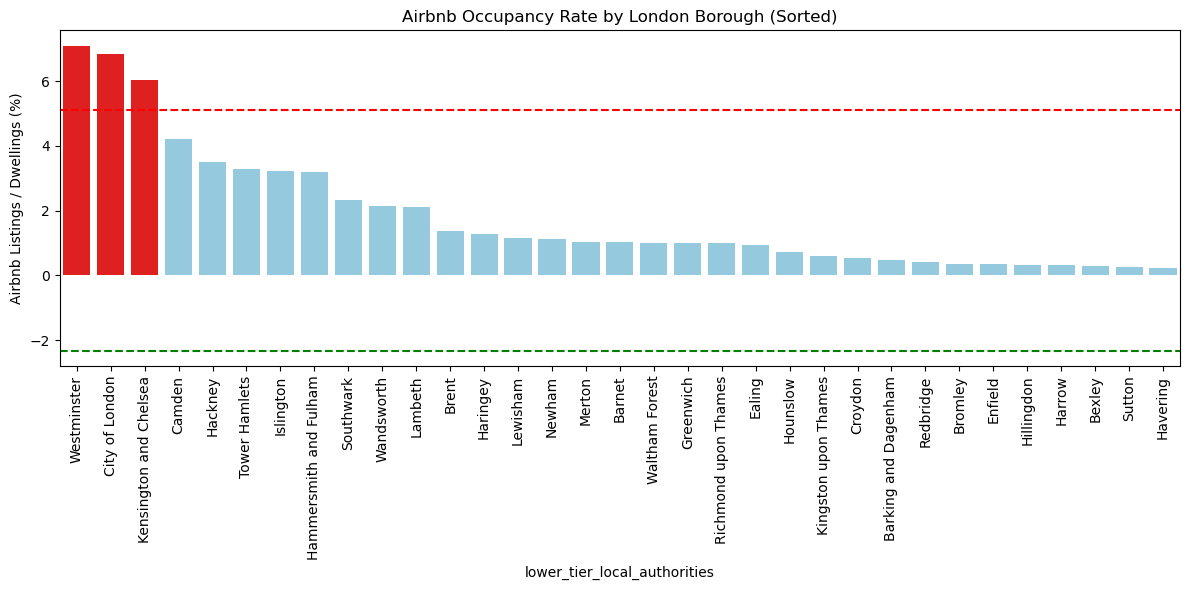

In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sort
merged_sorted = merged.sort_values('rate', ascending=False).reset_index(drop=True)

# calculate IQR
q1 = merged_sorted['rate'].quantile(0.25)
q3 = merged_sorted['rate'].quantile(0.75)
iqr = q3 - q1

high_threshold = q3 + 1.5 * iqr
low_threshold = q1 - 1.5 * iqr

# 直接一行生成 'significance' 列
merged_sorted['significance'] = ['high' if r > high_threshold else 'low' if r < low_threshold else 'medium' for r in merged_sorted['rate']]


plt.figure(figsize=(12,6))

sns.barplot(
    data=merged_sorted,
    x='lower_tier_local_authorities',
    y='rate_pct',
    hue='significance',         # 用 hue 映射颜色
    palette={'high':'red', 'medium':'skyblue', 'low':'green'},
    dodge=False                 # 不分组堆叠，柱子对齐
)

plt.xticks(rotation=90)
plt.ylabel('Airbnb Listings / Dwellings (%)')
plt.title('Airbnb Occupancy Rate by London Borough (Sorted)')
plt.axhline(y=high_threshold*100, color='red', linestyle='--', label='High threshold')
plt.axhline(y=low_threshold*100, color='green', linestyle='--', label='Low threshold')
plt.legend().remove()  # 如果不想显示 hue 图例
plt.tight_layout()
plt.show()



In [221]:
mean_rate = merged['listing_count'].sum() / merged['observation'].sum()
mean_rate * 100

np.float64(1.6838404922637047)

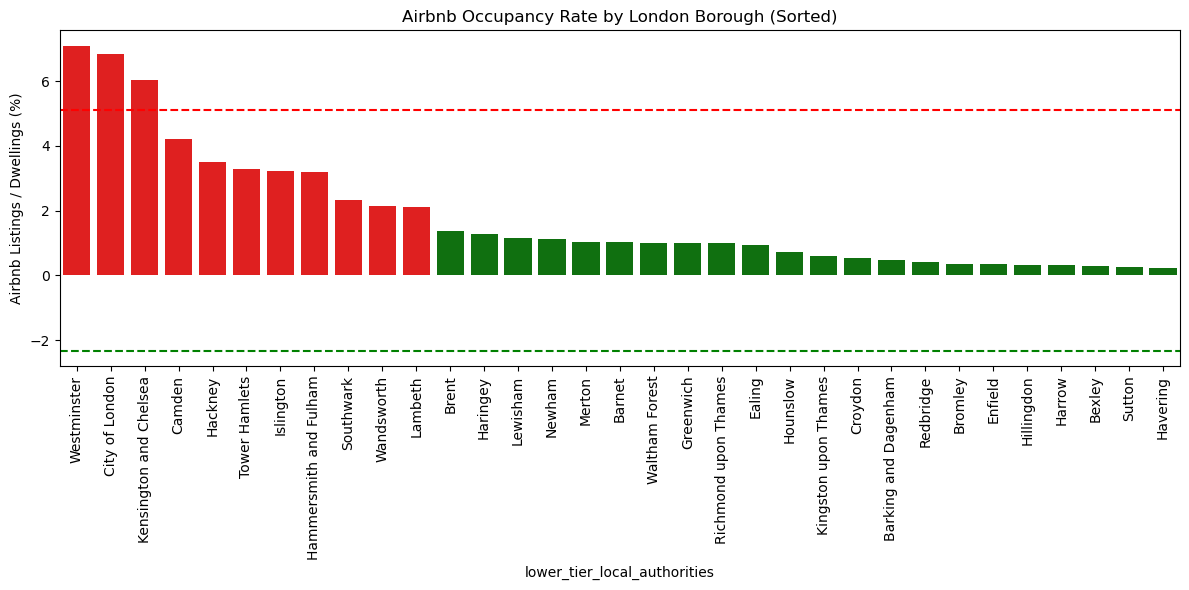

In [222]:
merged_sorted['significance'] = ['high' if r > mean_rate else 'low' if r < mean_rate else 'medium' for r in merged_sorted['rate']]


plt.figure(figsize=(12,6))

sns.barplot(
    data=merged_sorted,
    x='lower_tier_local_authorities',
    y='rate_pct',
    hue='significance',         # 用 hue 映射颜色
    palette={'high':'red', 'medium':'skyblue', 'low':'green'},
    dodge=False                 # 不分组堆叠，柱子对齐
)

plt.xticks(rotation=90)
plt.ylabel('Airbnb Listings / Dwellings (%)')
plt.title('Airbnb Occupancy Rate by London Borough (Sorted)')
plt.axhline(y=high_threshold*100, color='red', linestyle='--', label='High threshold')
plt.axhline(y=low_threshold*100, color='green', linestyle='--', label='Low threshold')
plt.legend().remove()  # 如果不想显示 hue 图例
plt.tight_layout()
plt.show()

In [223]:
boros.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,count_entire,count_private
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.6 160201.8, 516407.3 16...",408,319
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.2 159504.7, 535005.5 15...",875,817
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.6 157530.4, 540361.2 15...",496,381
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.8 178100, 521967.7 1780...",771,576
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.5 182881.6, 510249.9 18...",1328,1040


In [224]:
boros_dwl_rate = boros.merge(merged_sorted, left_on='GSS_CODE', right_on='lower_tier_local_authorities_code', how='left')
boros_dwl_rate

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,count_entire,count_private,lower_tier_local_authorities_code,lower_tier_local_authorities,observation,listing_count,rate,rate_pct,significance
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.6 160201.8, 516407.3 16...",408,319,E09000021,Kingston upon Thames,68885,408,0.005923,0.592292,low
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.2 159504.7, 535005.5 15...",875,817,E09000008,Croydon,162273,877,0.005404,0.540447,low
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.6 157530.4, 540361.2 15...",496,381,E09000006,Bromley,142083,496,0.003491,0.349092,low
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.8 178100, 521967.7 1780...",771,576,E09000018,Hounslow,108133,772,0.007139,0.713936,low
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.5 182881.6, 510249.9 18...",1328,1040,E09000009,Ealing,142126,1328,0.009344,0.934382,low
5,Havering,E09000016,11445.735,210.763,F,"MULTIPOLYGON (((549893.9 181459.8, 549894.6 18...",259,257,E09000016,Havering,106557,259,0.002431,0.243062,low
6,Hillingdon,E09000017,11570.063,0.000,F,"MULTIPOLYGON (((510599.8 191689.5, 510615.2 19...",379,568,E09000017,Hillingdon,115474,379,0.003282,0.328212,low
7,Harrow,E09000015,5046.330,0.000,F,"MULTIPOLYGON (((510599.8 191689.5, 510660 1916...",290,358,E09000015,Harrow,94793,290,0.003059,0.305930,low
8,Brent,E09000005,4323.270,0.000,F,"MULTIPOLYGON (((525201 182512.6, 525181.5 1825...",1773,1234,E09000005,Brent,127861,1773,0.013867,1.386662,low
9,Barnet,E09000003,8674.837,0.000,F,"MULTIPOLYGON (((524579.9 198355.2, 524594.3 19...",1591,925,E09000003,Barnet,156147,1592,0.010196,1.019552,low


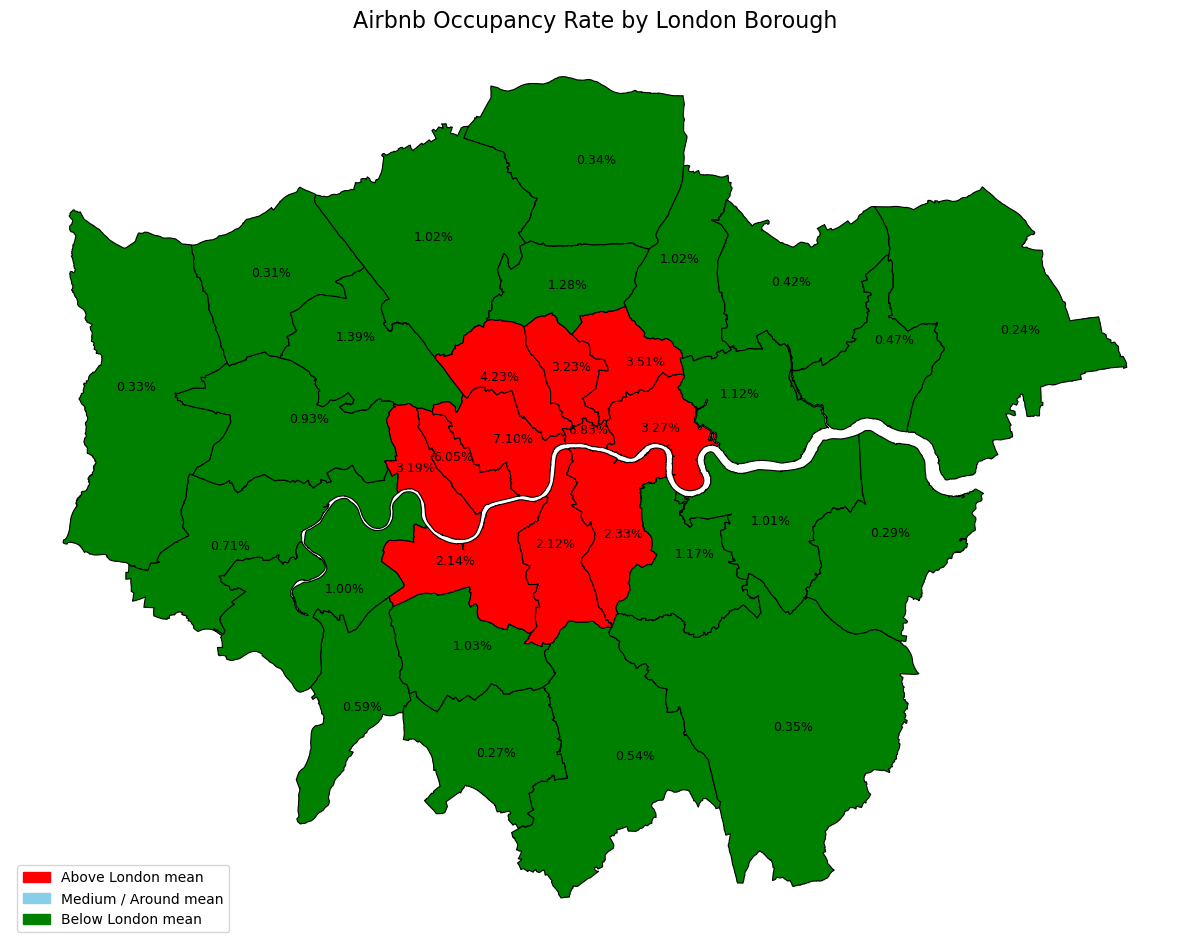

In [226]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


color_dict = {'high':'red', 'medium':'skyblue', 'low':'green'}
boros_dwl_rate['color'] = boros_dwl_rate['significance'].map(color_dict)


fig, ax = plt.subplots(1, 1, figsize=(12,12))
boros_dwl_rate.plot(ax=ax, color=boros_dwl_rate['color'], edgecolor='black', linewidth=0.8)


for idx, row in boros_dwl_rate.iterrows():
   
    x, y = row['geometry'].representative_point().x, row['geometry'].representative_point().y
    ax.text(x, y, f"{row['rate_pct']:.2f}%", horizontalalignment='center', fontsize=9)


red_patch = mpatches.Patch(color='red', label='Above London mean')
blue_patch = mpatches.Patch(color='skyblue', label='Medium / Around mean')
green_patch = mpatches.Patch(color='green', label='Below London mean')
plt.legend(handles=[red_patch, blue_patch, green_patch], loc='lower left')


plt.title('Airbnb Occupancy Rate by London Borough', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


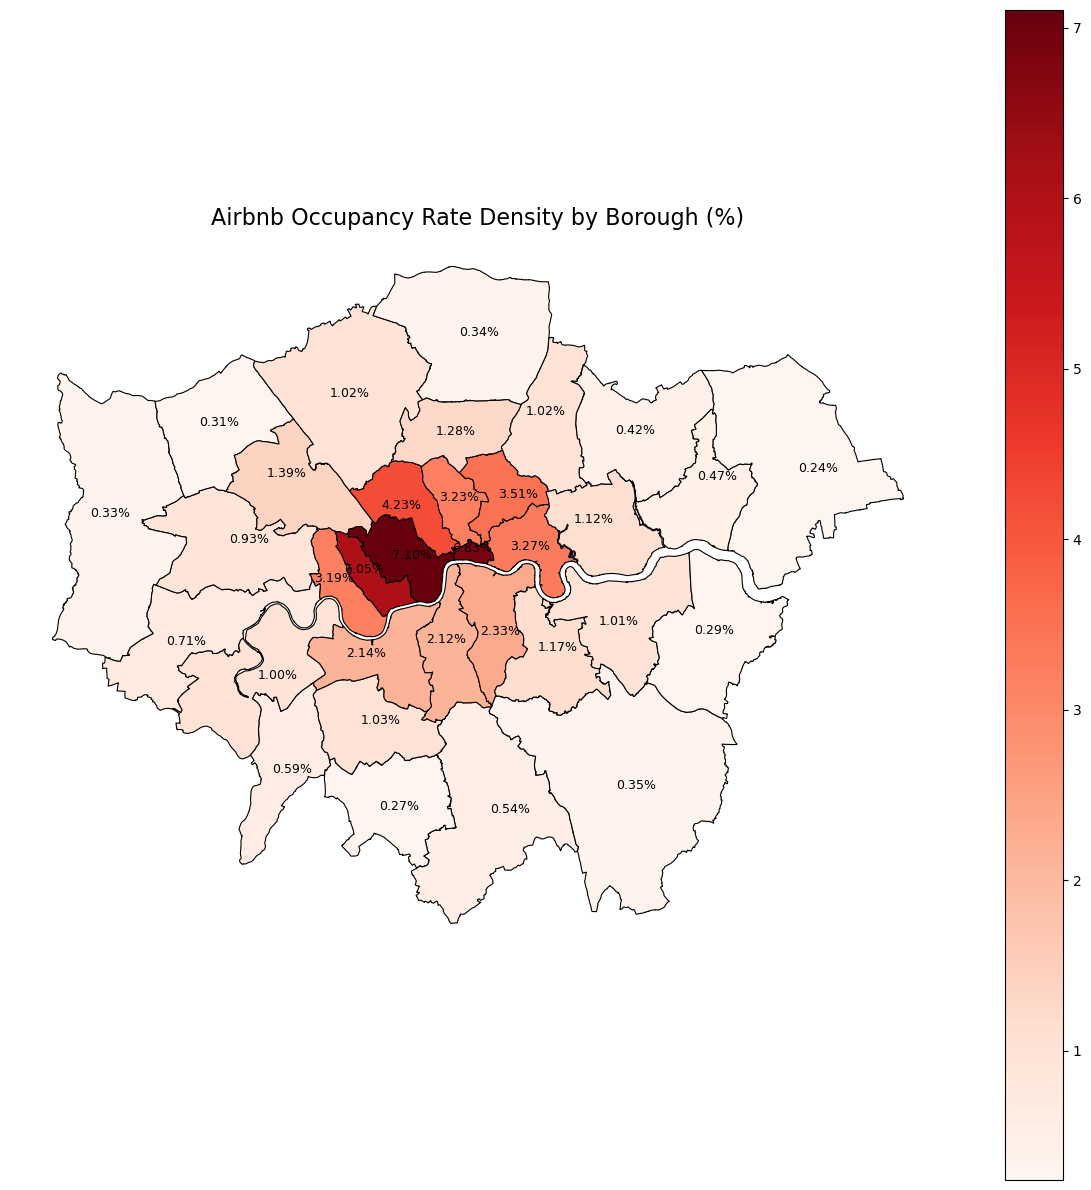

In [229]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

fig, ax = plt.subplots(1, 1, figsize=(12,12))

boros_dwl_rate.plot(
    column='rate_pct', 
    cmap='Reds', 
    linewidth=0.8, 
    edgecolor='black', 
    legend=True, 
    ax=ax
)

for idx, row in boros_dwl_rate.iterrows():
    x, y = row['geometry'].representative_point().x, row['geometry'].representative_point().y
    ax.text(x, y, f"{row['rate_pct']:.2f}%", horizontalalignment='center', fontsize=9)

ax.set_axis_off()
plt.title('Airbnb Occupancy Rate Density by Borough (%)', fontsize=16)
plt.tight_layout()
plt.show()


In [230]:
# 空置率
# 数据来源：Table 615: vacant dwellings by local authority district: England, from 2004
# https://www.gov.uk/government/statistical-data-sets/live-tables-on-dwelling-stock-including-vacants#live-tables-on-vacant-stock
# 数据局限性：此空置数据计算来源为
# 计算获取的数值在正常的空置率可及范围内
# All vacants: All vacant dwellings by local authority district, England, from 2004
# 无法获取rental market的空置数据，
# airbnb listings与vacancy rate都是基于整体dwelling统计数据，抵消一部分局限，但不会消除完全
# 准确的分析还需要获取rental market的数据
vacant = pd.read_csv("vacant_local.csv")
print(vacant.head())


vacant.columns = (
    vacant.columns
      .str.strip()        # 去前后空格
      .str.lower()        # 全部小写
      .str.replace(" ", "_")  # 空格变 _
      .str.replace(r"[^a-z0-9_]", "", regex=True)  # 去除特殊字符
)


cols_vacant_count = ['ons_code', '07102024']
vacant_24 = vacant[cols_vacant_count]
vacant_24.head()

    ONS code                Area 01/11/2004 10/10/2005 09/10/2006 08/10/2007  \
0  E92000001             England    710,935    723,509    744,931    763,319   
1  E12000001          North East     45,732     47,598     48,287     48,099   
2  E07000157             Alnwick        571        635      1,064        742   
3  E07000158  Berwick-upon-Tweed        614        651        674        669   
4  E07000159        Blyth Valley        789        860        888      1,018   

  06/10/2008 05/10/2009 04/10/2010 03/10/2011  ... 05/10/2015 03/10/2016  \
0    783,119    770,496    737,147    719,352  ...    600,179    589,766   
1     50,375     47,243     46,399     45,269  ...     40,784     40,579   
2        790        [x]        [x]        [x]  ...        [x]        [x]   
3        686        [x]        [x]        [x]  ...        [x]        [x]   
4      1,107        [x]        [x]        [x]  ...        [x]        [x]   

  02/10/2017 01/10/2018 07/10/2019 05/10/2020 04/10/2021 03/10

,ons_code,07102024
0,E92000001,"719,470"
1,E12000001,"42,617"
2,E07000157,[x]
3,E07000158,[x]
4,E07000159,[x]


In [231]:
vacant_24 = vacant_24.rename(columns={'07102024': 'vacant'})

dwelling_stat = pd.merge(dwl, vacant_24, how='left', left_on='lower_tier_local_authorities_code', right_on='ons_code')

dwelling_stat = dwelling_stat.drop(columns=['ons_code'])
print(dwelling_stat)

   lower_tier_local_authorities_code lower_tier_local_authorities  \
0                          E09000001               City of London   
1                          E09000002         Barking and Dagenham   
2                          E09000003                       Barnet   
3                          E09000004                       Bexley   
4                          E09000005                        Brent   
5                          E09000006                      Bromley   
6                          E09000007                       Camden   
7                          E09000008                      Croydon   
8                          E09000009                       Ealing   
9                          E09000010                      Enfield   
10                         E09000011                    Greenwich   
11                         E09000012                      Hackney   
12                         E09000013       Hammersmith and Fulham   
13                         E090000

In [232]:
dwelling_stat['vacant'] = dwelling_stat['vacant'].str.replace(',', '').astype(int)
dwelling_stat['vacant_rate'] = dwelling_stat['vacant'] / dwelling_stat['observation']
dwelling_stat['vacant_rate_perc'] = dwelling_stat['vacant_rate'] * 100
print(dwelling_stat)

   lower_tier_local_authorities_code lower_tier_local_authorities  \
0                          E09000001               City of London   
1                          E09000002         Barking and Dagenham   
2                          E09000003                       Barnet   
3                          E09000004                       Bexley   
4                          E09000005                        Brent   
5                          E09000006                      Bromley   
6                          E09000007                       Camden   
7                          E09000008                      Croydon   
8                          E09000009                       Ealing   
9                          E09000010                      Enfield   
10                         E09000011                    Greenwich   
11                         E09000012                      Hackney   
12                         E09000013       Hammersmith and Fulham   
13                         E090000

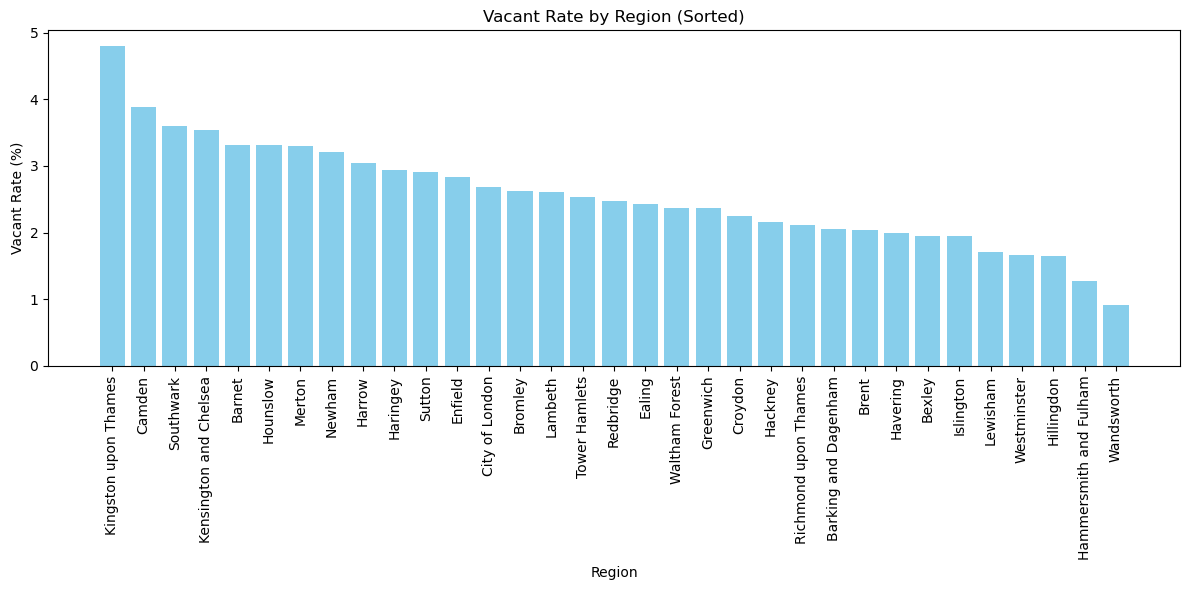

In [233]:


import matplotlib.pyplot as plt

# 按 vacant_rate_perc 降序排序
dwelling_stat_sorted = dwelling_stat.sort_values('vacant_rate_perc', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(dwelling_stat_sorted['lower_tier_local_authorities'], dwelling_stat_sorted['vacant_rate_perc'], color='skyblue')

plt.xlabel('Region')
plt.ylabel('Vacant Rate (%)')
plt.title('Vacant Rate by Region (Sorted)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [238]:

cols_to_merge = ['lower_tier_local_authorities_code', 'vacant_rate_perc', 'observation']
boros_dwell_vac = boros_dwl_rate.merge(
    dwelling_stat[cols_to_merge],
    left_on='GSS_CODE',
    right_on='lower_tier_local_authorities_code',
    how='left'
)
boros_dwell_vac

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,count_entire,count_private,lower_tier_local_authorities_code_x,lower_tier_local_authorities,observation_x,listing_count,rate,rate_pct,significance,color,lower_tier_local_authorities_code_y,vacant_rate_perc,observation_y
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.6 160201.8, 516407.3 16...",408,319,E09000021,Kingston upon Thames,68885,408,0.005923,0.592292,low,green,E09000021,4.794948,68885
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.2 159504.7, 535005.5 15...",875,817,E09000008,Croydon,162273,877,0.005404,0.540447,low,green,E09000008,2.249912,162273
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.6 157530.4, 540361.2 15...",496,381,E09000006,Bromley,142083,496,0.003491,0.349092,low,green,E09000006,2.619596,142083
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.8 178100, 521967.7 1780...",771,576,E09000018,Hounslow,108133,772,0.007139,0.713936,low,green,E09000018,3.313512,108133
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.5 182881.6, 510249.9 18...",1328,1040,E09000009,Ealing,142126,1328,0.009344,0.934382,low,green,E09000009,2.435867,142126
5,Havering,E09000016,11445.735,210.763,F,"MULTIPOLYGON (((549893.9 181459.8, 549894.6 18...",259,257,E09000016,Havering,106557,259,0.002431,0.243062,low,green,E09000016,1.991422,106557
6,Hillingdon,E09000017,11570.063,0.000,F,"MULTIPOLYGON (((510599.8 191689.5, 510615.2 19...",379,568,E09000017,Hillingdon,115474,379,0.003282,0.328212,low,green,E09000017,1.644526,115474
7,Harrow,E09000015,5046.330,0.000,F,"MULTIPOLYGON (((510599.8 191689.5, 510660 1916...",290,358,E09000015,Harrow,94793,290,0.003059,0.305930,low,green,E09000015,3.047693,94793
8,Brent,E09000005,4323.270,0.000,F,"MULTIPOLYGON (((525201 182512.6, 525181.5 1825...",1773,1234,E09000005,Brent,127861,1773,0.013867,1.386662,low,green,E09000005,2.036587,127861
9,Barnet,E09000003,8674.837,0.000,F,"MULTIPOLYGON (((524579.9 198355.2, 524594.3 19...",1591,925,E09000003,Barnet,156147,1592,0.010196,1.019552,low,green,E09000003,3.320589,156147


In [263]:
# 不太符合想要的结果，加入了邻居，跟筛选逻辑对不上了。去掉
'''
!pip install esda

import libpysal
import esda
import geopandas as gpd

# swm
w = libpysal.weights.Queen.from_dataframe(boros_dwell_vac)
w.transform = 'r'

# Bivariate Moran Local
bivariate_lisa = esda.Moran_Local_BV(boros_dwell_vac['rate_pct'], boros_dwell_vac['vacant_rate_perc'], w)


boros_dwell_vac['lisa_sig'] = bivariate_lisa.q 

'''


/tmp/ipykernel_65/3062050855.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(boros_dwell_vac)


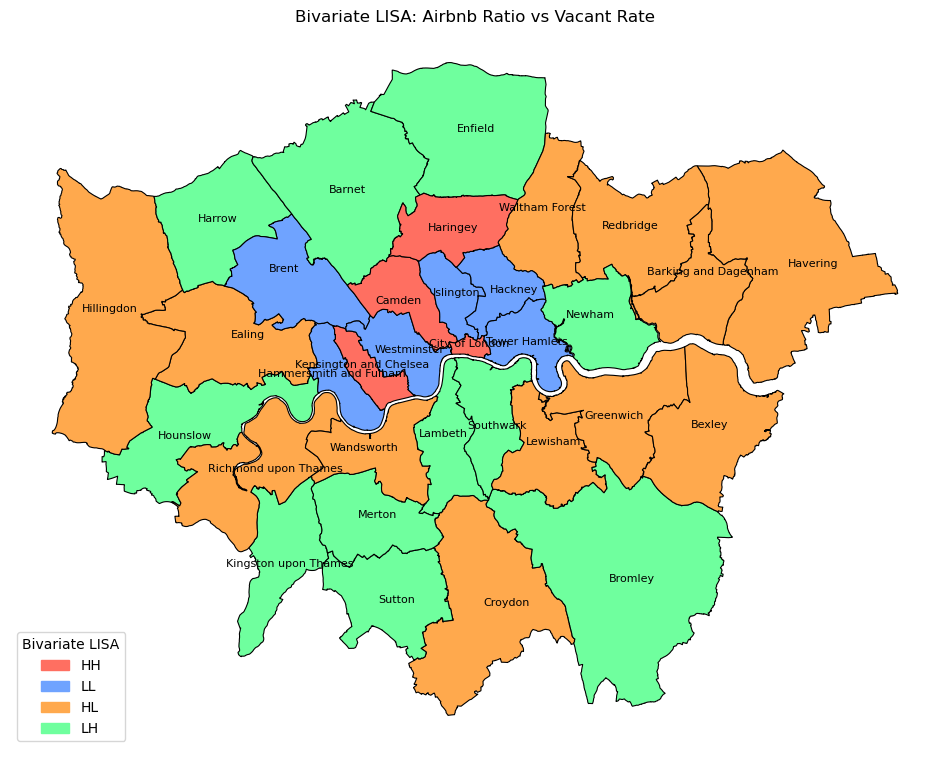

In [260]:
'''
color_dict = {
    1: '#FF6F61',  # HH 红色系
    2: '#6FA3FF',  # LL 蓝色系
    3: '#FFA94D',  # LH 橙色系
    4: '#6FFF9E',  # HL 绿色系
}



fig, ax = plt.subplots(1, 1, figsize=(12,12))
boros_dwell_vac.plot(
    color=boros_dwell_vac['color'],
    edgecolor='black',
    linewidth=0.8,
    ax=ax
)

for idx, row in boros_dwell_vac.iterrows():
    # 获取多边形内部一个代表点，避免文字跑到边界外
    x, y = row['geometry'].representative_point().x, row['geometry'].representative_point().y
    ax.text(x, y, row['NAME'], horizontalalignment='center', fontsize=8, color='black')


# 添加图例
legend_patches = [
    mpatches.Patch(color='#FF6F61', label='HH'),
    mpatches.Patch(color='#6FA3FF', label='LL'),
    mpatches.Patch(color='#FFA94D', label='HL'),
    mpatches.Patch(color='#6FFF9E', label='LH'),
]
ax.legend(handles=legend_patches, title='Bivariate LISA', loc='lower left')

plt.title('Bivariate LISA: Airbnb Ratio vs Vacant Rate')
plt.axis('off')
plt.show()
'''

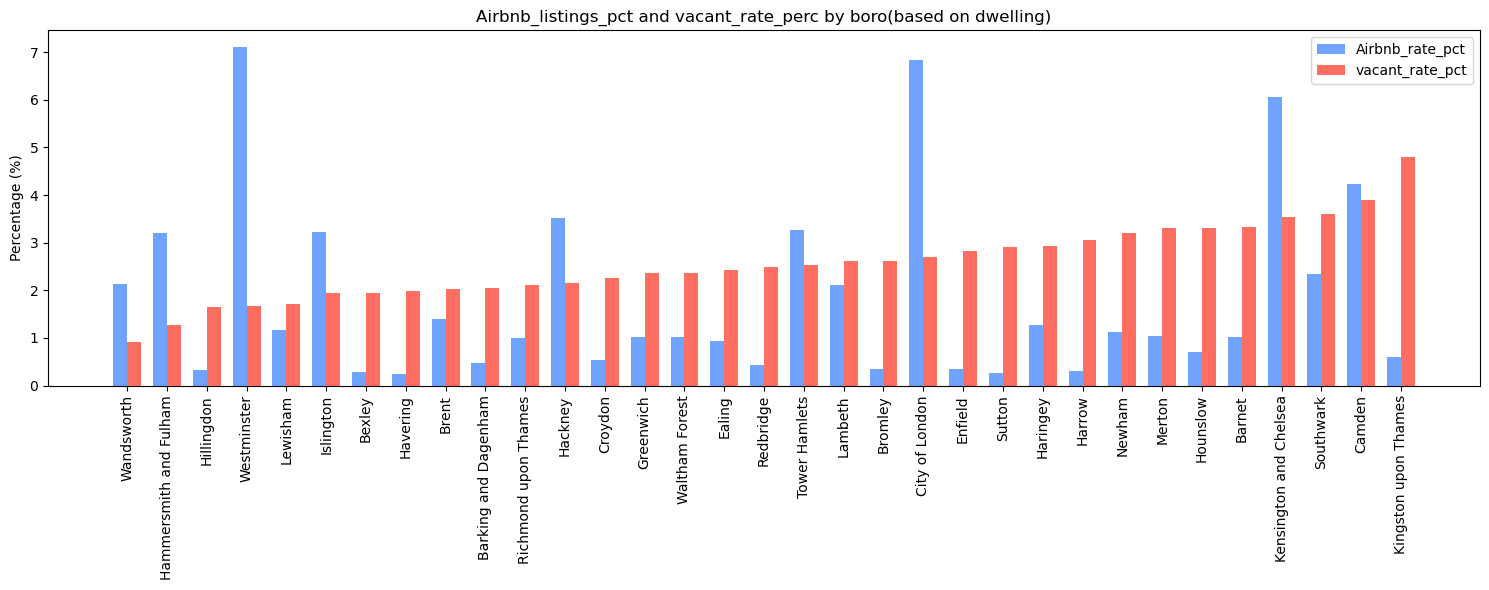

In [272]:
# 1️⃣ 按 vacant_rate_perc 排序
df_sorted = boros_dwell_vac.sort_values('vacant_rate_perc')

# 2️⃣ X轴位置
x = np.arange(len(df_sorted))  # 每个区域一个位置
width = 0.35  # 每根柱子的宽度

# 3️⃣ 绘制柱状图
fig, ax = plt.subplots(figsize=(15,6))

ax.bar(x - width/2, df_sorted['rate_pct'], width, label='Airbnb_rate_pct', color='#6FA3FF')
ax.bar(x + width/2, df_sorted['vacant_rate_perc'], width, label='vacant_rate_pct', color='#FF6F61')

# 4️⃣ 设置 X轴
ax.set_xticks(x)
ax.set_xticklabels(df_sorted['NAME'], rotation=90)  # 名称倾斜显示
ax.set_ylabel('Percentage (%)')
ax.set_title('Airbnb_listings_pct and vacant_rate_perc by boro(based on dwelling)')
ax.legend()

plt.tight_layout()
plt.show()

In [265]:
# 设置阈值，例如：
high_airbnb_threshold = boros_dwell_vac['rate_pct'].quantile(0.75)   # Airbnb 前25%
low_vacant_threshold = boros_dwell_vac['vacant_rate_perc'].quantile(0.50)  # 空置率低于中位数

# 筛选目标区域
target_areas = boros_dwell_vac[
    (boros_dwell_vac['rate_pct'] >= high_airbnb_threshold) &
    (boros_dwell_vac['vacant_rate_perc'] <= low_vacant_threshold)
]

# 查看结果
target_areas[['NAME', 'rate_pct', 'vacant_rate_perc']]


,NAME,rate_pct,vacant_rate_perc
22,Hammersmith and Fulham,3.193997,1.272432
24,Westminster,7.103295,1.666253
27,Islington,3.231118,1.942974
28,Hackney,3.512089,2.160030


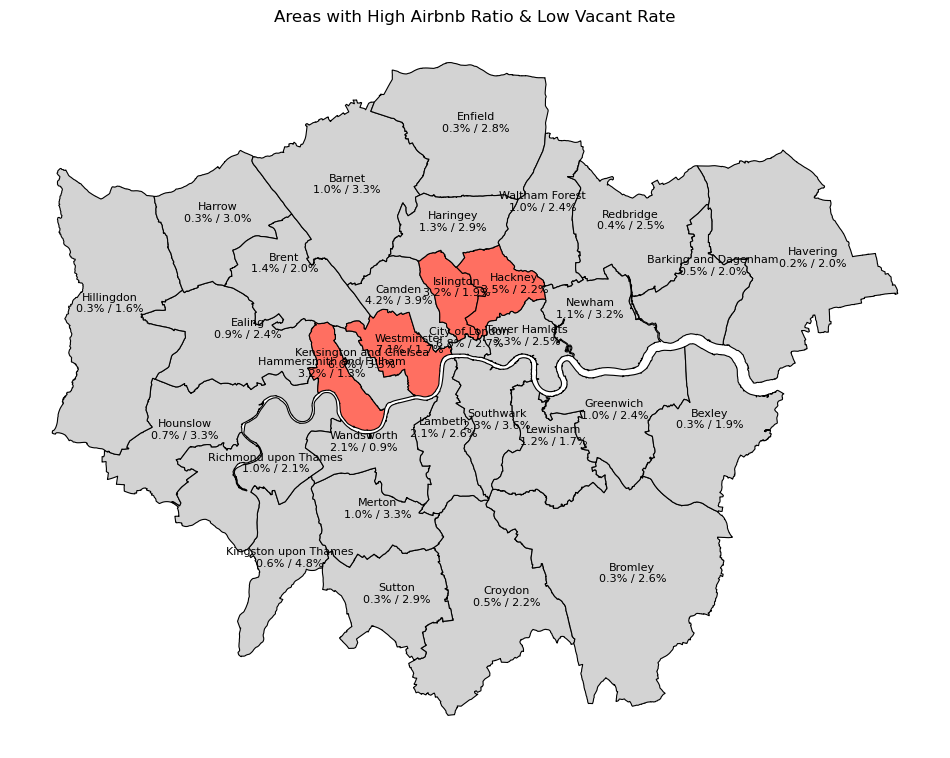

In [266]:
boros_dwell_vac['color'] = '#D3D3D3'  # 默认灰色
boros_dwell_vac.loc[
    (boros_dwell_vac['rate_pct'] >= high_airbnb_threshold) &
    (boros_dwell_vac['vacant_rate_perc'] <= low_vacant_threshold),
    'color'
] = '#FF6F61'  # 红色

# 绘图
fig, ax = plt.subplots(1,1,figsize=(12,12))
boros_dwell_vac.plot(color=boros_dwell_vac['color'], edgecolor='black', linewidth=0.8, ax=ax)

# 标注 NAME + 数值
for idx, row in boros_dwell_vac.iterrows():
    x, y = row['geometry'].representative_point().x, row['geometry'].representative_point().y
    ax.text(x, y, f"{row['NAME']}\n{row['rate_pct']:.1f}% / {row['vacant_rate_perc']:.1f}%", 
            horizontalalignment='center', fontsize=8, color='black')

plt.title('Areas with High Airbnb Ratio & Low Vacant Rate')
plt.axis('off')
plt.show()


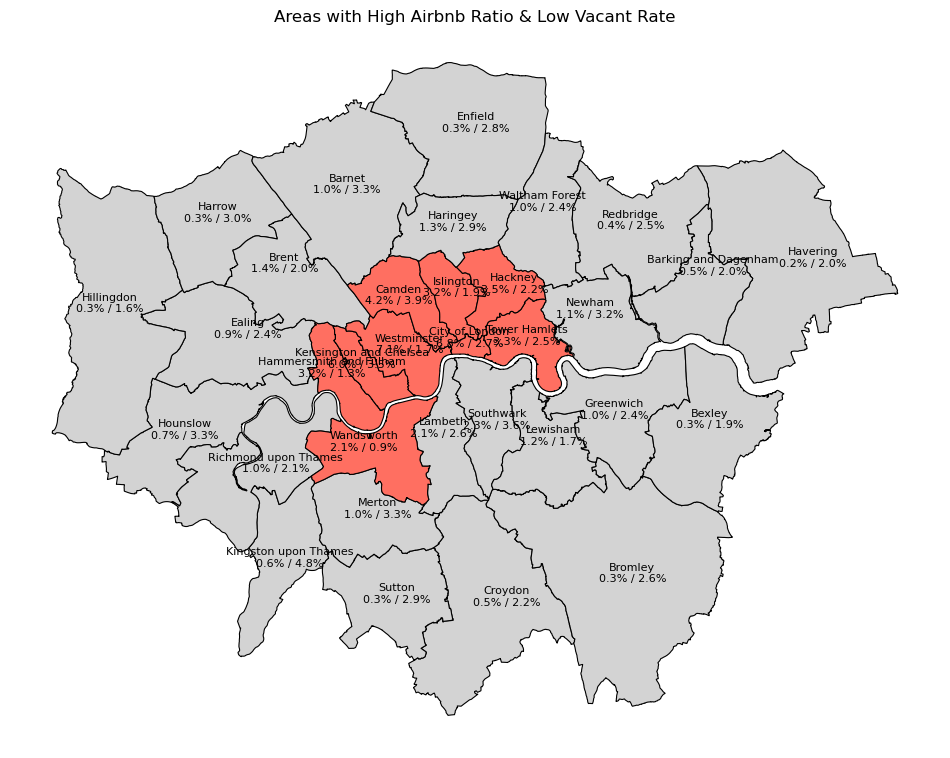

In [267]:
boros_dwell_vac['score'] = boros_dwell_vac['rate_pct'] / boros_dwell_vac['vacant_rate_perc']

# 取前 25% 作为高 Airbnb / 低空置率
threshold = boros_dwell_vac['score'].quantile(0.75)
target_areas = boros_dwell_vac[boros_dwell_vac['score'] >= threshold]

target_areas[['NAME', 'rate_pct', 'vacant_rate_perc', 'score']]


# 默认灰色
boros_dwell_vac['color'] = '#D3D3D3'

# 标注高 score 区域
boros_dwell_vac.loc[boros_dwell_vac['score'] >= threshold, 'color'] = '#FF6F61'  # 红色

# 绘图
fig, ax = plt.subplots(1,1,figsize=(12,12))
boros_dwell_vac.plot(color=boros_dwell_vac['color'], edgecolor='black', linewidth=0.8, ax=ax)

# 标注 NAME + 数值
for idx, row in boros_dwell_vac.iterrows():
    x, y = row['geometry'].representative_point().x, row['geometry'].representative_point().y
    ax.text(x, y, f"{row['NAME']}\n{row['rate_pct']:.1f}% / {row['vacant_rate_perc']:.1f}%", 
            horizontalalignment='center', fontsize=8, color='black')

plt.title('Areas with High Airbnb Ratio & Low Vacant Rate')
plt.axis('off')
plt.show()


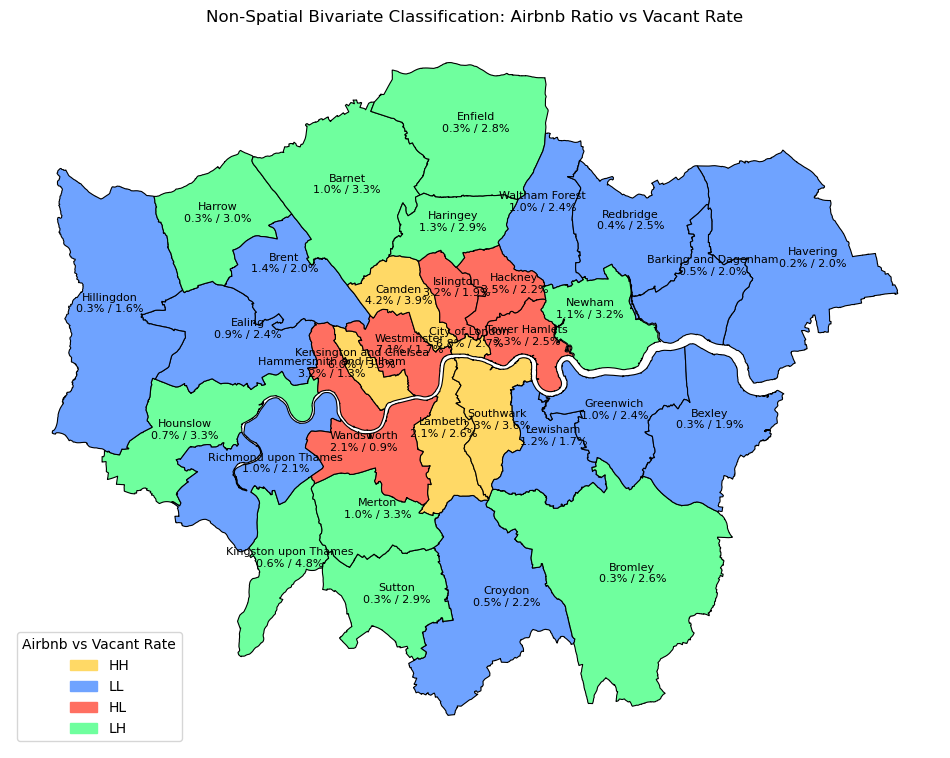

In [270]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# 定义高低阈值（可以用中位数或均值）
airbnb_median = boros_dwell_vac['rate_pct'].mean()
vacant_median = boros_dwell_vac['vacant_rate_perc'].mean()

# 分类
def classify(row):
    if row['rate_pct'] >= airbnb_median and row['vacant_rate_perc'] >= vacant_median:
        return 'HH'
    elif row['rate_pct'] < airbnb_median and row['vacant_rate_perc'] < vacant_median:
        return 'LL'
    elif row['rate_pct'] >= airbnb_median and row['vacant_rate_perc'] < vacant_median:
        return 'HL'
    else:
        return 'LH'

boros_dwell_vac['combo_class'] = boros_dwell_vac.apply(classify, axis=1)

# 映射颜色
color_dict = {
    'HH': '#FFD966',  # 黄色
    'LL': '#6FA3FF',  # 蓝色
    'HL': '#FF6F61',  # 红色
    'LH': '#6FFF9E',  # 绿色
}
boros_dwell_vac['color'] = boros_dwell_vac['combo_class'].map(color_dict)

# 绘图
fig, ax = plt.subplots(1,1,figsize=(12,12))
boros_dwell_vac.plot(color=boros_dwell_vac['color'], edgecolor='black', linewidth=0.8, ax=ax)

# 标注 NAME + 数值
for idx, row in boros_dwell_vac.iterrows():
    x, y = row['geometry'].representative_point().x, row['geometry'].representative_point().y
    ax.text(x, y, f"{row['NAME']}\n{row['rate_pct']:.1f}% / {row['vacant_rate_perc']:.1f}%", 
            horizontalalignment='center', fontsize=8, color='black')

# 添加图例
legend_patches = [
    mpatches.Patch(color=color_dict['HH'], label='HH'),
    mpatches.Patch(color=color_dict['LL'], label='LL'),
    mpatches.Patch(color=color_dict['HL'], label='HL'),
    mpatches.Patch(color=color_dict['LH'], label='LH'),
]
ax.legend(handles=legend_patches, title='Airbnb vs Vacant Rate', loc='lower left')

plt.title('Non-Spatial Bivariate Classification: Airbnb Ratio vs Vacant Rate')
plt.axis('off')
plt.show()



In [ ]:
Olivia

In [ ]:
# Vacancy Rate
# --- 1. Load Data ---
ddir_2 = Path('data/airbnb')
spath_2 = 'https://raw.githubusercontent.com/JianlingZhao/fsds_Airbnb_dwelling_data/main/'
vacant = pd.read_csv( cache_data(spath_2 + 'vacant_local.csv', ddir_2) )
print('Done.')

# --- 2. Clean Data ---
# Strip whitespace from headers to prevent KeyErrors
dwl.columns = dwl.columns.str.strip()
vacant.columns = (
    vacant.columns.str.strip().str.lower()
    .str.replace(" ", "_").str.replace(r"[^a-z0-9_]", "", regex=True)
)

# Process Vacancy Data (Oct 2024)
target_col = '07102024'
if target_col in vacant.columns:
    vacant_24 = vacant[['ons_code', target_col]].copy()
else:
    # Fallback to the last column if specific date is missing
    vacant_24 = vacant.iloc[:, [0, -1]].copy()
vacant_24.columns = ['ons_code', 'vacant']

# Fix numbers (remove commas, handle '[x]')
vacant_24['vacant'] = pd.to_numeric(
    vacant_24['vacant'].astype(str).str.replace(',', ''), 
    errors='coerce'
).fillna(0).astype(int)

# --- 3. Merge ---
# We use the column INDEX [0] (the Code) to merge safely
dwelling_stat = pd.merge(
    dwl, vacant_24, how='inner', 
    left_on=dwl.columns[0], right_on='ons_code'
)

# --- 4. Fail-Safe Rename (The Fix) ---
# Instead of guessing the name "Lower tier...", we grab the name at Index 1
original_name_col = dwl.columns[1]  # This is the Borough Name column
original_count_col = dwl.columns[2] # This is the Observation/Count column

dwelling_stat = dwelling_stat.rename(columns={
    original_name_col: 'Borough',
    original_count_col: 'Total_Dwellings'
})

# --- 5. Plot ---
dwelling_stat['vacant_rate_perc'] = (dwelling_stat['vacant'] / dwelling_stat['Total_Dwellings']) * 100
df_plot = dwelling_stat.sort_values('vacant_rate_perc', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_plot['Borough'], df_plot['vacant_rate_perc'], color='skyblue', edgecolor='black')
plt.title('Vacancy Rate by Borough (2024)', fontsize=14)
plt.xlabel('Borough')
plt.ylabel('Vacant Rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print Top 5
print(df_plot[['Borough', 'vacant_rate_perc']].head())